# 5. 神经网络

In [27]:
# preparation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

from prml import nn

np.random.seed(1234)

在3，4两章中，我们讨论了固定基函数的线性组合构成的回归和分类模型。我们看到这样的模型具有有用的分析与计算性质，但是在实际应用中它们被维数灾难问题限制了。为了将这些模型应用于大规模的问题，需要根据数据调节基函数。

第7章中讨论的支持向量机（SVM）首先定义以训练数据点为中心的基函数，然后在训练过程中选择子集来决解这个问题。SVM的一个优点是尽管训练涉及非线性优化，目标函数是凸的，因此最优问题的解相对直接的。虽然通常来说最终模型中基函数的数量很多，且通常随着数据规模的增加而增加，但是它远小于训练数据点的数量。相关向量机（7.2节中讨论）同样从基函数固定集合中选择子集，通常会生成一个相当稀疏的模型。与SVM不同，它也产生概率形式的输出，虽然这会导致训练阶段的非凸优化开销。

另一种方法是事先固定基函数的数量，但是允许调节它们，也就是说使用在训练阶段可调节的参数形式的基函数。在模型识别中，这种方法最成功的模型是将在本章讨论的前馈神经网络，也被称为多层感知器（multilayer perceptron）。实际上，“多层感知器”是一个相当不正确的命名，因为模型是由多层logistic回归模型（带有连续的非线性性质），而不是由多层感知器（带有非连续的非线性性质）组成。对于很多应用来说，得到的模型比具有同样泛化能力的支持向量机简洁的多，因此计算的速度更快。这种简洁性的代价是，与相关向量机一样，构成了网络训练根基的似然函数不再是模型参数的凸函数。然而，在实际应用中，考察模型在训练阶段消耗的计算资源来得到一个简洁的模型是很有价值的，它可以快速地处理新数据。

术语“神经网络”来源于它尝试寻找生物系统中的信息处理的数学表示（McCulloch and Pitts, 1943; Widrow and Hoff, 1960; Rosenblatt, 1962; Rumelhart et al., 1986）。实际上，这个模型已经被广泛使用，涵盖了相当多的不同种类的模型，许多模型过分夸张地宣称其具有生物学的似真性。然而，从模式识别的实际应用角度来说，模仿生物的真实性会带来相当多的不必要的限制。因此，本章中，我们把注意力集中于作为统计模式识别的高效模型的神经网络。特别地，我们要把注意力集中于已经被证明有相当大的实用价值的神经网络的一个具体的类别上，这就是神经网络的多层感知器。

我们以考虑神经网络的函数形式，包括基函数的具体参数开始。然后我们讨论使用最大似然框架确定神经网络参数的问题，这涉及到非线性最优化问题的解。这种方法需要计算对数似然函数关于神经网络参数的导数，我们看到这些导数可以使用误差反向传播（error backpropagation）的方法高效的获得。我们还会说明误差反向传播的框架如何推广到计算其它导数，例如Jacobian矩阵和Hessian矩阵。接下来，我们讨论神经网络训练的各种正则化方法，及方法之间的关系。我们还会考虑神经网络模型的一些扩展。特别地，会描述一个被称为混合密度网络（mixture density network）的通用框架来对条件密度建模。最后，我们讨论神经网络的贝叶斯观点运用。额外的关于神经网络模型的背景可以参考Bishop(1995a)。

## 5.1 前馈神经网络

3，4章中分别讨论的线性模型的回归和分类是基于固定非线性基函数$ \phi_j(x) $的线性组合，且具有
$ y(x,w) = f\left(\sum\limits_{j=1}^Mw_j\phi_j(x)\right) \tag{5.1} $
其中$ f(\dot) $在分类中是非线性激活函数，在回归中是恒等函数。我们的目标是使这些基函数$ \phi_j(x) $依赖于参数，从而能在训练阶段调节这些参数及系数$ {w_j} $来推广这些模型。当然，有许多种方法构造参数化的非线性基函数。神经网络使用与式（5.1）相同形式的基函数，即每个基函数本身是输入的线性组合的非线性函数，其中线性组合的系数是可调节参数。
这就引入了可以被描述为一系列的函数变换的，基本神经网络模型。首先，我们构造形式为
$ a_j = \sum\limits_{i=1}^Dw_{ji}^{(1)}x_i = w_{j0}^{(1)} \tag{5.2} $
的输入变量$ x_1,...,x_D $的$ M $个线性组合。其中$j = 1,...,M $且上标$ (1) $表示对应的参数是神经网络的第一“层”。根据第3章中的命名规则，我们把参数$ w_{ji}^{(1)} $称为权重（weights），参数$ w_{j0}^{(1)} $称为偏置（biases）。$ a_j $称为激活（activations）。它们都使用一个可微的非线性激活函数（activation function）$ h(\dot) $进行变换，得到
$ z_j = h(a_j) \tag{5.3} $
这些量对应式（5.1）中的基函数的输出，这些基函数在神经网络中被称为隐含单元（hidden unit）。非线性函数$ h(\dot) $通常选择为sigmoidal函数，例如logistic sigmoid函数或双曲正切函数。根据式（5.1）再次线性组合这些值得到输出单元激活（output unit activations）：
$ a_k = \sum\limits_{j=1}^Mw_{kj}^{(2)}z_j + w_{k0}^{(2)} \tag{5.4} $
其中$ k = 1,...,K $且$ K $是输出的总数。这个变换对应网络的第二层，同样的$ w_{k0}^{(2)} $表示偏置参数。最后，输出单元激活通过合适的激活函数变换得到网络的输出集合$ y_k $。激活函数是由数据本身以及目标变量的假定分布确定的，并遵循3，4章的线性模型确定激活函数的过程。所以，对于标准的回归问题，激活函数是恒等式$ y_k = a_k $。同样的，对于多个二元分类问题，每个输出单元激活使用logistic sigmoid函数进行变换，即
$ y_k = \sigma(a_k) \tag{5.5} $
其中
$ \sigma(a) = \frac{1}{1+exp(-a)} \tag{5.6} $
最后，对于多分类问题，我们使用了式（4.62）给出的softmax激活函数。输出单元激活函数的选择在5.2节中会详细讨论。
我们可以将各个阶段结合，得到整体的网络函数。对于sigmoid输出单元激活函数，整体的网络函数为
$ y_k(x,w) = \sigma\left(\sum\limits_{j=1}^Mw_{kj}^{(2)}h\left(\sum\limits_{i=1}^Dw_{ji}^{(1)}x_i + w_{j0}^{(1)}\right) + w_{k0}^{(2)}\right) \tag{5.7} $
其中，所有权参数和偏置参数被组合到一起记作向量$ w $。因此神经网络模型可以简单地看成一个从输入变量$ {x_i} $到输出变量$ {y_k} $的非线性函数，并由可调节参数向量$ w $控制。
这个函数可以表示成图5.1展示的网络图的形式

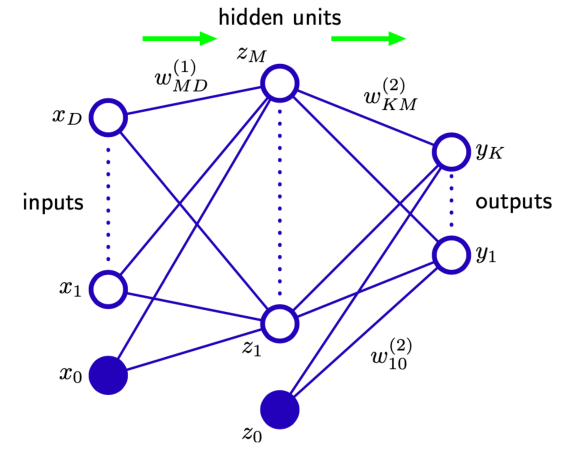

In [21]:
# 图5.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.1.png')
plt.axis('off')
ax.imshow(d)

图 5.1 网络图
这样，计算式（5.7）的过程可以看成信息通过网络前向传播（forward propagation）。需要强调的是，因为这些图的内部结点表示的是确定的变量而不是随机变量，所以这并不是第8章将要讨论的概率图模型。由于这个原因，我们为这两个模型采用的稍微不同的图形标记。稍后我们将会看到如何给出神经网络的概率解释。
正如3.1节中讨论的那样，式（5.2）中的偏置参数可以通过定义一个额外的输入变量$ x_0 $（值被固定为$ x_0 = 1 $）来吧偏置参数包含在权重参数中，那么（5.2）就变成
$ a_j = \sum\limits_{i=0}^Dw_{ji}^{(1)}x_i \tag{5.8} $
的形式。
我们同样可以把第二层的偏置包含在第二层的权重中，这样整体的网络函数就变成了：
$ y_k(x,w) = \sigma\left(\sum\limits_{j=0}^Mw_{kj}^{(2)}h\left(\sum\limits_{i=0}^Dw_{ji}^{(1)}x_i\right)\right) \tag{5.9} $
正如从图5.1中可以看到的那样，神经网络模型由两个处理阶段组成，每个阶段都类似于4.1.7节讨论的感知器模型，因此神经网络也被称为多层感知器（multilayer perceptron），或MLP。然而，与感知器模型相比，一个重要的区别是神经网络在隐含单元中使用连续的sigmoid非线性函数，而感知器使用阶梯函数这一非线性函数。这意味着神经网络函数关于神经网络参数是可微的，这个性质在神经网络的训练过程中起着重要的作用。
如果网络中的所有隐含单元的激活函数都取线性函数，由于连续的线性变换的组合也是是一个线性变换，所以对于这种网络，我们总可以找到一个等价的无隐含单元的网络。然而，如果隐含单元的数量小于输入单元的数量或者小于输出单元的数量，那么网络能够产生的变换不是最一般的从输入到输出的线性变换，因为在隐含单元出的维度降低造成了信息丢失。在12.4.2节，我们将展示线性单元的网络可以引出主成分分析。但是通常情况下，我们对线性单元的多层神经网络几乎不感兴趣。
图5.1给出的网络结构是在实际中最常用的一个。而且，它很容易扩展。例如，可以增加额外的处理层，每层包含一个由式（5.4）得到的加权线性组合，以及一个使用非线性激活函数进行的元素级别的变换。注意，在文献中，关于计算这种网络的层数，有一些混淆的地方。因此图5.1中的网络可能被描述成一个3层网络（计算单元的层数，把输入当成单元），或有时被当作一个单一隐含层网络（计算隐含单元层的数量）。我们推荐的计算方法是把图5.1的网络称为两层网络，因为这是对于确定网络性质很重要的可调节权值的层数。
神经网络结构的另一个扩展是引入跨层（skip-layer）链接，每个跨层链接都关联着一个对应的可调节参数。例如，在一个两层的神经网络中，跨层链接可能直接从输入链接到输出。原则上，有着sigmoid隐含单元的网络总能通过使用足够小的第一层权值，从而使得隐含单元几乎是线性的，然后将隐含单元到输出的权值设置为足够大来进行补偿，来模拟跨层链接（对于有界输入值）。然而在实际应用中，显示地包含跨层链接可能会更方便。
此外，网络可以是稀疏的。稀疏的网络中，并不是所有有可能的链接方式都被链接上。在5.5.6节讨论卷积神经网络时，我们会看到一个稀疏网络的例子。
由于在网络图和它的数学函数表达式之间有一个直接的对应关系，因此我们可以通过考虑更复杂的网络图来构造更一般的网络映射。然而，这些网络必须被限制为前馈（feed-forward）结构，也就是说，网络中不能存在有向圈，从而确保了输出是输入的确定函数。图5.2用一个简单的例子说明了这一点。

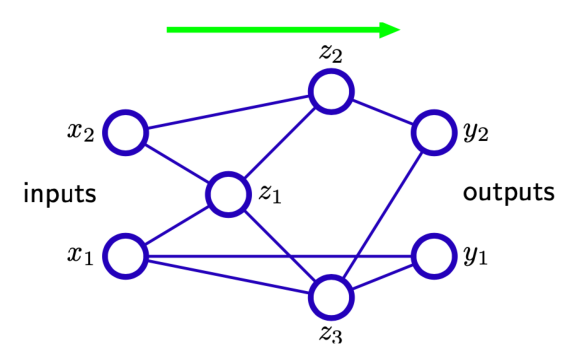

In [23]:
# 图5.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.2.png')
plt.axis('off')
ax.imshow(d)

这样的网络中每个（隐含或输出）单元都计算了一个形式为
$ z_k = h\left(\sum\limits_jw_{kj}z_j\right) \tag{5.10} $
函数。其中，求和的对象是所有向单元$ k $发送链接的单元（偏置参数也包含在了求和式当中）。对于一组给定的值作用在神经网络的输入上，不断应用式（5.10）使得网络中所有单元（包括输出单元）的激活都能够被计算出来。
广泛研究前馈网络的近似性质（Funahashi, 1989; Cybenko, 1989; Hornik et al., 1989; Stinchecombe and White, 1989; Cotter, 1990; Ito, 1991; Hornik, 1991; Kreinovich, 1991; Ripley, 1996）这些性质被发现相当通用。因此神经网络被称为通用近似（universal approximator）。 例如，一个带有线性输出的两层网络，只要隐含单元的数量足够多，可以在任意精度下近似任何输入变量较少的连续函数。这个结果对于一大类隐含单元激活函数都成立，但是不包括多项式函数。虽然这些定理是毋庸置疑的，但关键问题是，给定一组训练数据，如何寻找合适的参数值。在本章的后续章节中，我们会说明，基于最大似然方法和贝叶斯方法来高效的解决这个问题。
图5.3说明了两层网络建模一大类函数的能力。这个图也说明了独立的隐含单元是如何联合地近似最终的函数的。

图5.4说明了在一个简单的分类问题中，隐含单元的作用。使用的数据集是附录A中描述的人工生成的分类数据。

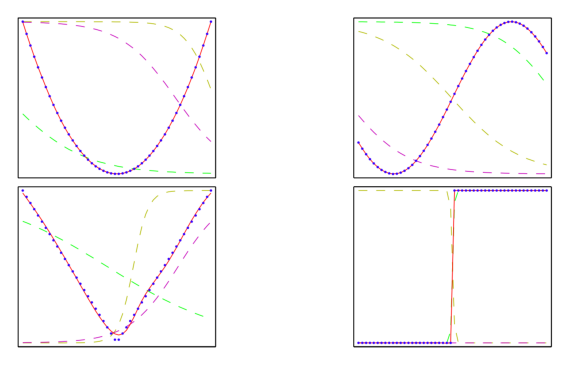

In [24]:
# 图5.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.3.png')
plt.axis('off')
ax.imshow(d)

In [3]:
# model
class RegressionNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter():
            self.w1 = nn.random.truncnormal(-2, 2, 1, (n_input, n_hidden))
            self.b1 = nn.zeros(n_hidden)
            self.w2 = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_output))
            self.b2 = nn.zeros(n_output)

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        return h @ self.w2 + self.b2

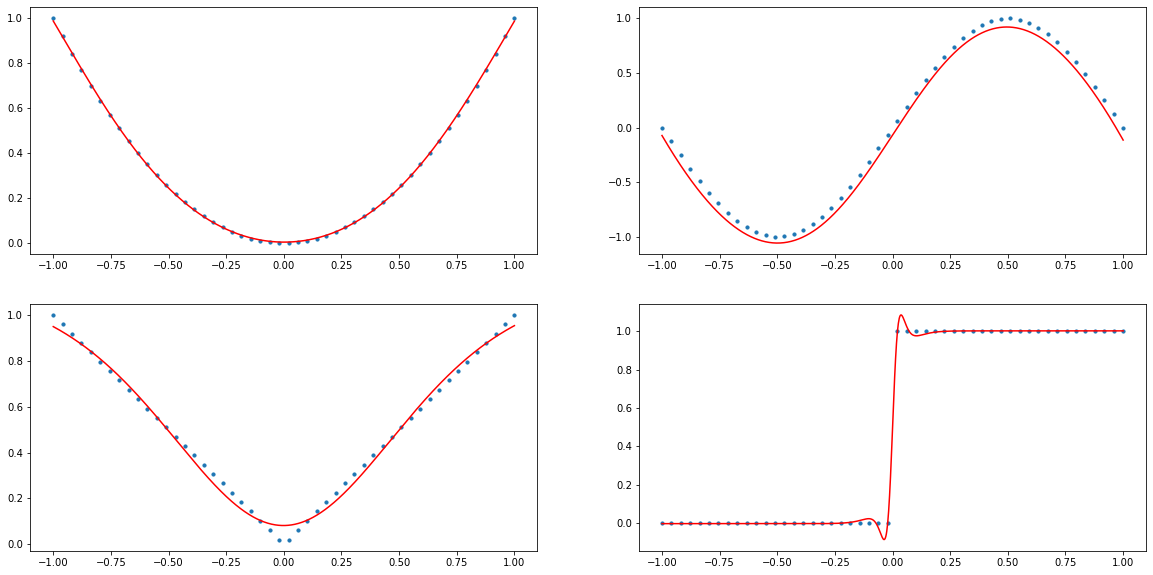

In [26]:
# result
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter in zip(range(1, 5), func_list, [1000, 10000, 10000, 10000]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = RegressionNetwork(1, 3, 1)
    optimizer = nn.optimizer.Adam(model.parameter, 0.1)
    for _ in range(n_iter):
        model.clear()
        loss = nn.square(y_train - model(x_train)).sum()
        optimizer.minimize(loss)
    y = model(x).value
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

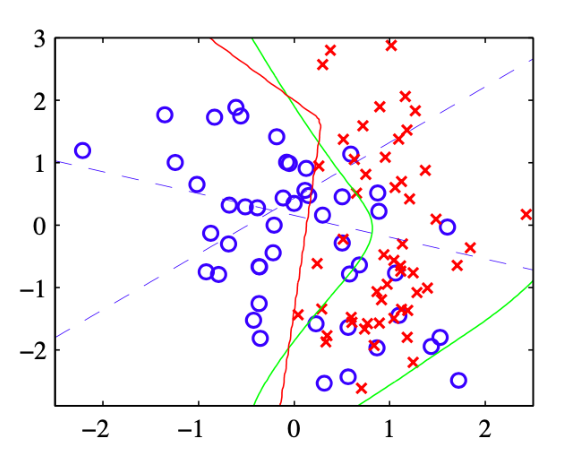

In [25]:
# 图5.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.4.png')
plt.axis('off')
ax.imshow(d)

## 5.2 网络训练

目前为止，我们把神经网络看成一大类从输入变量向量$ x $到输出变量向量$ y $的参数非线性函数。确定网络参数的一种简单方法类似于我们在1.1节对多项式曲线拟合问题的讨论：最小化平方和误差函数。给定一个由输入向量$ {x_n} n = 1,...,N $组成的训练集，以及对应的目标向量$ t_n $组成的集合，最小化误差函数
$ E(w) = \frac{1}{2}\sum\limits_{n=1}^N\Vert y(x_n,w) - t_n \Vert^2 \tag{5.11} $
然而，通过给网络的输出提供一个概率形式的表示，我们可以给网络训练提供一个更加一般的观点。在1.5.4节中我们已经看到使用概率预测的很多优势。这里它给我们输出单元的非线性函数及误差函数的选择提供一个清晰的动机。
我们以讨论回归问题开始，现在我们只考虑可以取任何实数值的一元目标变量$ t $的情形。根据1.2.5与3.1节中的讨论，我们假设$ t $是均值依赖$ x $由神经网络的输出确定的高斯分布：
$ p(t|x, w) = \mathcal{N}(t|y(x,w),\beta^{-1}) \tag{5.12} $
其中$ \beta $是高斯噪声的精度（方差的逆）。当然，这种假设有些严格。在5.6节中，我们将会看到如何扩展这个方法来允许更一般的条件分布。对于（5.12）给出的条件分布，将输出单元激活函数取成恒等函数就足够了，因为这样的网络可以近似任何从$ x $到$ y $的连续函数。给定一个由$ N $个独立同分布的观测组成的数据集$ X = {x_1,...,x_N} $，以及对应的目标值$ t = {t_1,...,t_N} $，我们可以构造对应的似然函数
$ p(t|X,w,\beta) = \prod\limits_{n=1}^N p(t_n|x_n,w,\beta) $
取对数的负，得到误差函数
$ \frac{\beta}{2}\sum\limits_{n=1}^N{y(x_n,w)-t_n}^2 - \frac{N}{2}\ln\beta + \frac{\beta}{2}\ln(2\pi) \tag{5.13} $
这可以用来学习参数$ w, \beta $。在5.7节，我们将会讨论神经网络的贝叶斯方法，现在我们考虑最大似然方法。注意，在神经网络的文献中，通常考虑最小化误差函数而不是最大化（对数）似然函数，因此这里我们遵循这个惯例。首先确定$ w $。最大化似然函数等价于最小化由
$ E(w) = \frac{1}{2}\sum\limits_{n=1}^N{y(x_n,w) - t_n}^2 \tag{5.14} $
给出的平方和误差函数。其中我们已经去掉了加上和乘以的常数。由于最小化$ E(w) $得到的$ w $的值对应最大似然解，所以我们把它记作$ w_{ML} $。在实际应用中，网络函数$ y(x_n, w) $的非线性性导致误差$ E(w) $是非凸的，因此在实际应用中找到的可能是似然函数的局部最大值，对应于误差函数的局部最小值，这将在5.2.1节讨论。
得到$ w_{ML} $后，$ \beta $的值可以通过最小化对数似然的负
$ \frac{1}{\beta_{ML}} = \frac{1}{N}\sum\limits_{n=1}^N{y(x_n,w_{ML}) - t_n}^2 \tag{5.15} $
注意，一旦我们寻找$ w_{ML} $的迭代最优化过程完成，就可以计算这个值。如果有多个目标变量，且假设给定$ x, w $的条件下，目标变量之间相互独立，且共享噪声精度$ \beta $，那么，目标变量的条件分布由
$ p(t|x,w) = \mathcal{N}(t|y(x,w),\beta^{-1}I) \tag{5.16} $
给出。使用与一元目标变量的情形相同的推导过程，我们看到最大似然的权值由最小化平方和误差函数（5.11）确定。于是噪声的精度由
$ \frac{1}{\beta_{ML}} = \frac{1}{NK}\sum\limits_{n=1}^N\Vert y(x_n,w_{ML}) - t_n \Vert^2 \tag{5.17} $
给出，其中$ K $是目标变量的数量。当没有独立性假设时，最优化问题变得稍微复杂一些。
回忆一下，根据4.3.6节的讨论，我们看到在误差函数（负对数似然函数）和输出单元激活函数之间有一个自然的对应关系。在回归问题中，我们可以把神经网络看成具有一个恒等$ y_k = a_k $输出激活函数的模型。对应的平方和误差函数具有
$ \frac{\partial E}{\partial a_k} = y_k - t_k \tag{5.18} $
性质。在5.3节讨论误差反向传播的时候，我们将会用到这几结果。
现在考虑有单一目标变量$ t $，且$ t = 1 $表示类别$ C_1 $，$ t = 0 $表示类别$ C_2 $的二分类问题。根据4.3.6节中对标准链接函数的讨论，我们考虑一个具有单一输出，以logistic sigmoid函数作为激活函数的网络
$ y = \sigma(a) \equiv \frac{1}{1+exp(-a)} \tag{5.19} $
所以$ 0 \leq y(x,w) \leq 1 $。我们可以把$ y(x,w) $解释为条件概率$ p(C_1|x) $，那么$ p(C_2|x) $的概率就是$ 1 - y(x,w) $。如果给定了输入。那么目标变量的条件概率分布是一个形式为
$ p(t|x,w) = y(x,w)^t{1-y(x,w)}^{1-t} \tag{5.20} $
的伯努利分布。如果我们考虑一个由独立观测组成的训练集，那么由负对数给出的误差函数是形式为
$ E(w) = -\sum\limits_{n=1}^N{t_n\ln y_n + (1-t_n)\ln (1-y_n)} \tag{5.21} $
的交叉熵误差函数。其中$ y_n $表示$ y(x_n,w) $。注意，由于我们假定目标值的标记都是正确的，所以这里没有与噪声精度$ \beta $相类似的东西。然而，模型可以容易的扩展到能够接受错误标记的情形。Simard et al.(2003)发现，对于分类问题，使用交叉熵误差函数的训练速度会比平方和误差函数更快，同时也提升了泛化能力。
如果我们有$ K $个相互独立的二分类问题，那么我们可以使用具有$ K $个以logistic sigmoid函数作为激活函数的输出的神经网络。与每个输出相关联的是一个二元类别标签$ t_k \in {0,1} k=1,...,K $。如果我们假设类标签是独立的，那么给定输入向量，目标向量的条件概率分布为
$ p(t|x,w) = \prod\limits_{k=1}^K y_k(x,w)^{t_k}[1-y_k(x,w)]^{1-t_k} \tag{5.22} $
取似然函数的负对数，可以得到误差函数
$ E(w) = -\sum\limits_{n=1}^N\sum\limits_{k=1}^K{t_{nk}\ln y_{nk} + (1 - t_{nk})\ln (1-y_nk)} \tag{5.23} $
其中$ y_{nk} $表示$ y_k(x_n, w) $。与回归问题一样，对于指定输出单元，误差函数关于激活的导数的形式为式（5.18）。
我们可以对比一下这个问题的神经网络解和第4章讨论的线性分类模型给出的解，来发现一些有趣的事情。假设我们使用图5.1所示的标准的两层神经网络。我们看到，网络第一层的权向量由各个输出所共享，而在线性模型中每个分类问题是独立地解决的。神经网络的第一层可以被看做进行了一个非线性的特征抽取，而不同的输出之间共享特征可以节省计算量，同时也提升了泛化能力。
最后，我们考虑标准的多分类问题，其中每个输入被分到$ K $个互斥的类别中。二元目标变量$ t_k \in {0,1} $使用“1-of-K”编码方式，从而网络的输出可以表示为$ y_k(x,w) = p(t_k = 1 | x) $，因此误差函数为
$ E(w) = -\sum\limits_{n=1}^N\sum\limits_{k=1}^K t_{nk}\ln y_k(x_n,w) \tag{5.24} $
根据4.3.4节的讨论，我们看到对应标准链接的输出单元激活函数有softmax函数：
$ y_k(x,w) = \frac{exp(a_k(x,w))}{\sum\limits_jexp(a_j(x,w))} \tag{5.25} $
给出。其中满足$ 0 \leq y_k \leq 1 $和$ \sum_ky_k = 1 $。注意，给所有的$ a_k(x,w) $都加上一个常数，$ y_k(x, w) $是不变的，这就使得误差函数在权空间的某些方向上是常数。如果我们给误差函数加上一个恰当的正则化项（第5.5节），那么这种问题就可以避免。
与之前一样，对于指定输出单元，误差函数关于激活的导数的函数形式为式（5.18）。
总而言之，根据解决的问题的类型，输出单元激活函数和对应的误差函数，存在一个自然的选择。对于回归问题，我们使用线性输出，平方和误差函数，对于（多独立的）二分类问题，我们使用logistic sigmoid输出以及交叉熵误差函数，对于多类别分类问题，我们使用softmax输出以及对应的多分类交叉熵错误函数。对于涉及到两个类别的分类问题，我们可以使用单一的logistic sigmoid输出，也可以使用有两个输出的，且输出激活函数为softmax函数的神经网络。



### 5.2.1 参数最优化

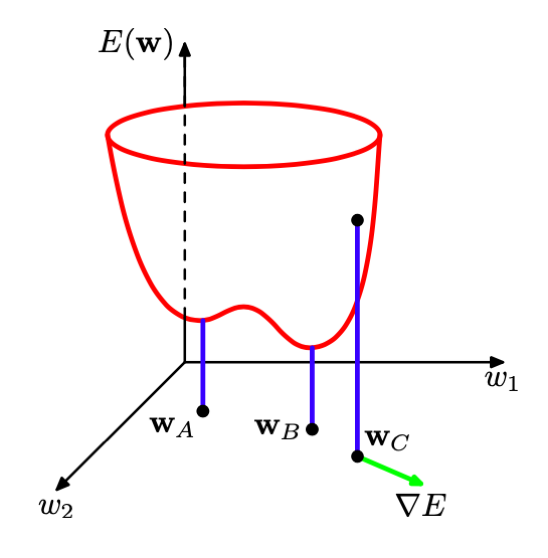

In [28]:
# 图5.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.5.png')
plt.axis('off')
ax.imshow(d)

接下来，我们考虑寻找能够使得选定的误差函数$ E(w) $达到最小值的权向量$ w $。现在，考虑误差函数的几何表示是很有用的。我们可以把误差函数看成位于权空间的一个曲面，如图5.5所示。首先注意到，如果我们在权空间从$ w $走到$ w + \delta w $，那么误差函数的改变为$ \delta E \simeq \delta w^T\nabla E(w) $，其中向量$ \nabla E(w) $在误差函数增加速度最大的方向上。由于误差$ E(w) $是$ w $的光滑连续函数，因此它的最小值出现在权空间中误差函数梯度等于零的位置上，即
$ \nabla E(w) = 0 \tag{5.26} $
不然我们就可以沿着方向$ −\nabla E(w) $走一小步，进一步减小误差。梯度为零的点被称为驻点，它可以进一步细分为极小值点、极大值点和鞍点。
我们的目标是寻找一个向量$ w $使得$ E(w) $取最小值。然而，误差函数通常与权值和偏置参数高度非线性的，因此权值空间中会有很多梯度为零（或梯度非常小）的点。实际上，根据5.1.1节的讨论，我们知道，对于任意一个局部极小值点$ w $，在权空间中都存在等价的其他极小值点。例如，在图5.1所示的两层神经网络中，有$ M $个隐含单元，权空间中的每个点都是$ M!2^M $个等价点中的一个。
此外，通常有多个不等价的驻点，通常会产生多个不等价的极小值。误差函数对于所有的权向量的最小值被称为全局最小值（golobal minimum）。任何其他的使误差函数的值较大的极小值被称为局部极小值（local minima）。对于一个可以成功使用神经网络的应用来说，可能没有必要寻找全局最小值（通常无法知道是否找到了全局最小值），而是通过比较几个局部极小值得到足够好的解。
由于无法找到方程$ \nabla E(w) = 0 $的解析解，因此我们使用迭代的数值方法。连续非线性函数的最优化问题已经被广泛研究，有相当多的文献讨论如何高效地解决它们。大多数方法涉及到为权向量选择某个初始值$ w_0 $然后在权空间中进行一系列移动形式为
$ w^{(\tau + 1)} = w^{(\tau)} + \Delta w^{(tau)} \tag{5.27} $
其中$ tau $表示迭代的次数。不同的算法涉及到权向量更新$ \Delta w^{(\tau)} $的不同选择。许多算法使用梯度信息，因此就需要在每次更新之后计算新的权向量$ w^{(\tau +1)} $处的$ \Delta E(w) $的值。为了理解梯度信息的重要性，有必要考虑误差函数基于泰勒展开的局部近似。



### 5.2.2 局部二次近似

考虑局部二次近似可以让我们更深入的认识最优化问题，得到更多解决这个问题的技术。
考虑$ E(w) $在权空间中某个点$ \hat{w} $处的泰勒展开
$ E(w) \simeq E(\hat{w}) + (w-\hat{w})^Tb + \frac{1}{2}(w-\hat{w})^TH(w-\hat{w}) \tag{5.28} $
其中我们省略了立方和更高阶的项。这里定义$ b $为$ E $的梯度在$ \hat{w} $处的值
$ b \equiv \nabla E|_{w=\hat{w}} \tag{5.29} $
且Hessian矩阵$ H = \nabla\nabla E $具元素
$$
\left.(\boldsymbol{H})_{i j} \equiv \frac{\partial E}{\partial w_{i} \partial w_{j}}\right|_{\boldsymbol{w}=\hat{\boldsymbol{w}}}
 \tag{5.30} $$
根据式（5.28）梯度对应的局部近似由
$ \nabla E \simeq b + H(w-\hat{w}) \tag{5.31} $
对于距离$ \hat{w} $充分近的点$ w $，这些表达式对误差函数和它的梯度给出了合理的近似。
考虑在误差函数最小值的点$ w^* $附近的局部二次近似的特殊情况。这种情况下，由于在$ w^* $处$ \nabla E = 0 $，所以没有线性项，式（5.28）变成$$
E(\boldsymbol{w}) \simeq E\left(\boldsymbol{w}^{*}\right)+\frac{1}{2}\left(\boldsymbol{w}-\boldsymbol{w}^{*}\right)^{T} \boldsymbol{H}\left(\boldsymbol{w}-\boldsymbol{w}^{*}\right)
\tag{5.32}$$
其中Hessian矩阵$ H $是在$ w^* $处计算的。为了以几何方式来解释，考虑Hessian矩阵的特征方程
$ Hu_i = \lambda_iu_i \tag{5.33} $
其中特征向量$ u_i $构成了完备正交集（附录C），即
$ u_i^Tu_j = \delta_{ij} \tag{5.34} $
现在，我们展开$ (w - w^*) $得到特征向量的线性组合形式
$ w - w^* = \sum\limits_i \alpha_iu_i \tag{5.35} $
这可以解释成，原点变成了点$ w^* $，并旋转坐标轴与特征向量对齐（通过以$ u_i $为列的正交矩阵）的坐标系统变换，在附录C中有更详细的讨论。把式（5.35）代入式（5.32）并使用式（5.33）及（5.34）得到误差函数可以写成
$ E(w) = E(w^*) + \frac{1}{2}\sum\limits_i\lambda_i\alpha_i^2 \tag{5.36} $
的形式。
矩阵$ H $是正定的，当且仅当
$ v^THv > 0, for all v \neq 0 \tag{5.37} $
因为特征向量$ {u_i} $组成了一个完备集，所以任意一个向量$ v $都可以写成
$ v = \sum\limits_ic_iu_i \tag{5.38} $
的形式。
根据（5.33）（5.34）得到
$ v^THv = \sum\limits_ic_i^2\lambda_i \tag{5.39} $
所以，当且仅当所有特征值为正的时候$ H $是正定的。图5.6展示了，在新的坐标系统中，基向量由特征向量$ {u_i} $给出，$ E $的等高线是以原点为中心的椭圆。
 
图 5.6 在最小值$ w^* $的邻域中，误差函数的二次函数近似
对于1维权空间，当
$ \left.\frac{\partial^2E}{\partial w^2}\vphantom{\Big|}\right| _{w^*} > 0 \tag{5.40} $
时，驻点$ w^* $是最小值。对于$ D $维权空间$ w^* $处的Hessian矩阵是正定时，驻点$ w^* $是最小值。



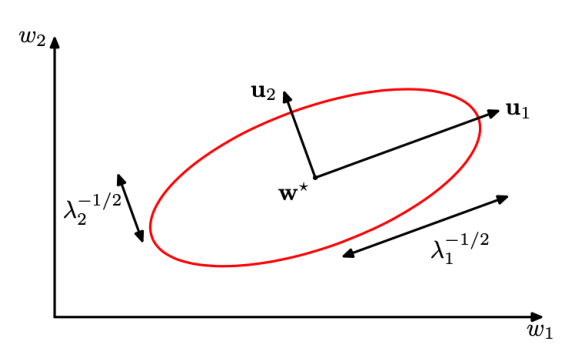

In [29]:
# 图5.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.6.png')
plt.axis('off')
ax.imshow(d)

### 5.2.3 使用梯度信息

正如我们将在5.3节看到的那样，误差函数的梯度可以通过误差反向传播的方法高效地计算出来。这个梯度信息的使用可以大幅度加快找到极小值点的速度。原因如下所述：
在式（5.28）给出的误差函数的二次近似中，误差曲面由$ b, H $确定，它包含了$ W(W+3) / 2 $个独立的元素（因为矩阵$ H $是对称的），其中$ W $是$ w $的维数（即网络中可调节参数的总数）。这个二次近似的局部最小值依赖于$ O(W^2) $个参数，并且我们不应该奢求在收集到$ O(W^2) $个条独立的信息之前就能够找到最小值。如果我们不使用梯度信息，我们不得不进行$ O(W^2) $次函数求值，每次求值都需要$ O(W) $个步骤。因此，使用这种方法求最小值的计算复杂度为$ O(W^3) $。
现在，把这种方法与使用梯度信息的算法做比较。由于每个$ \nabla E $的计算带来$ W $个信息，所以我们预计找到函数的最小值需要$ O(W) $次梯度计算，每个这样的计算只需要进行$ O(W) $步，所以最小值可以在$ O(W^2) $步内找到。由于这个原因，使用梯度信息构成了训练神经网络的实际算法的基础。



### 5.2.4 梯度下降最优化

最简单的使用梯度信息的方法是，在负梯度方向上的一次小的移动作为式（5.27）的权值更新方法，即
$ w^{(tau + 1)} = w^{(tau)} - \eta\nabla E(w^{(tau)}) \tag{5.41} $
其中$ \eta > 0 $被称为学习率（learning rate）。经过这样的更新之后，梯度会根据新的权值向量重新计算，然后重复这个过程。注意，误差函数是根据训练集定义的，因此每次$ \nabla E $的计算都要处理整个训练集。一次使用所有数据的技术被称为批方法（batch method）。每一次权向量都会沿着误差函数下降速度最快的方向移动，所以这个方法被称为梯度下降法（gradient descent）或最陡峭下降法（steepest descent）。这种方法在直觉上看比较合理，但实际证明它是一个很差的算法，原因可以参考Bishop and Nabney(2008)。
对于批量最优化，存在更高效的方法，例如共轭梯度法（conjugate gradient）或拟牛顿法(quasi-Newton)。与简单的梯度下降方法相比，这些方法更健壮，更快（Gill et al., 1981; Fletcher, 1987; Nocedal and Wright, 1999）。与梯度下降方法不同，这些算法具有：除非权向量到达了局部的或全局的最小值，否则误差函数在每次迭代时总是减小的性质。
为了找到一个足够好的极小值，可能需要多次运行基于梯度的算法，每次都使用一个不同的随机选择的起始点，然后在一个独立的验证集上对比最终的表现。
然而，梯度下降法有一个被证明在实际应用中对于使用大规模数据集来训练神经网络的情形很有用的在线的版本（LeCun et al., 1989）。基于一组独立观测的最大似然函数的误差函数由一个求和式构成，每个数据点有
$ E(w) = \sum\limits_{n=1}^N E_n(w) \tag{5.42} $
在线梯度下降，也被称为顺序梯度下降（sequential gradient descent）或随机梯度下降（stochastic gradient descent）权向量的更新每次只依赖于一个数据点，即
$ w^{(\tau + 1)} = w^{(\tau)} - \eta\nabla E_n(w^{(tau)}) \tag{5.43} $
这个更新在数据集上循环重复进行，并且既可以顺序地处理数据，也可以随机地有重复地选择数据点。当然，也有折中的方法，即每次更新依赖于数据点的一小部分。
与批处理相比，在线方法的一个优点是可以更加高效地处理数据中的冗余性。为了说明这一点，让我们考虑这样一种极端的情形：给定一个数据集，我们将每个数据点都复制一次，从而将数据集的规模翻倍。注意这仅仅把误差函数乘以了一个因子$ 2 $，因此等价于使用原始的误差函数。批处理方法必须付出两倍的计算量来计算误差函数的梯度，而在线方法不受影响。在线梯度下降方法的另一个性质是：因为整个数据集的关于误差函数的驻点通常不会是每个数据点各自的驻点，所以它可以逃离局部最小值点。
非线性最优化算法，以及它们对于神经网络训练的实际应用，在Bishop and Nabney(2008)中有详细的讨论。



## 5.3 误差反向传播

这节我们的目标是找到一种能快速计算出前馈神经网络的误差函数$ E(w) $的梯度的技术。我们会看到这可以通过信息在神经网络中交替地向前、向后传播，这种被称为误差反向传播（error backpropagation）有时被简称为“反传”的技术来达到。
注意，术语“反向传播”在神经网络计算的文献中，用于指代许多不同的事物。如：多层感知器体系节后有时被称为反向传播网络。术语“反向传播”也被用来描述将梯度下降法应用于平方和误差函数的多层感知器的训练过程。为了不让概念发生混淆，仔细研究一下训练过程的本质是很有用的。大部分训练算法涉及到最小化误差函数的一个权值调节的迭代过程。在每一个这样迭代过程中，我们可以分为两个不同的阶段。在第一个阶段，误差函数关于权值的导数必须被计算出来。正如我们稍后会看到的那样，反向传播技术的一个重要的贡献是提供了高效计算这些导数的方法。由于这个阶段误差通过网络进行反向传播，所以我们专门使用反向传播这个术语来描述计算导数的过程。在第二个阶段，导数用于计算权值的调整量。最简单的方法，也是最先由Rumelhart et al.(1986)提出的方法，涉及到梯度下降。认识到这两个阶段的不同是很重要的。因此，第一阶段，即为了计算导数而进行的误差在网络中的反向传播阶段，可以应用于许多其他种类的网络，而不仅仅是多层感知器。它也可以应用于其他的误差函数，而不仅仅是简单的平方和误差函数。它也可以用于计算其他类型的导数，如Jacobian矩阵和Hessian矩阵，正如我们将在本章后面看到的那样。类似地，第二阶段，即通过得到的导数调整权值的阶段，可以使用许多本质上比简单的梯度下降更强大的最优化方法处理。



In [5]:
# model
class ClassificationNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter():
            self.w1 = nn.random.truncnormal(-2, 2, 1, (n_input, n_hidden))
            self.b1 = nn.zeros(n_hidden)
            self.w2 = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_output))
            self.b2 = nn.zeros(n_output)

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        return h @ self.w2 + self.b2

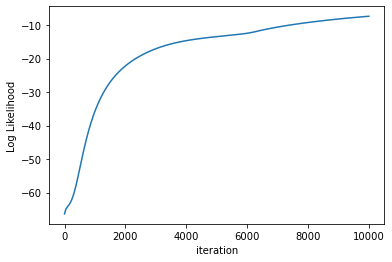

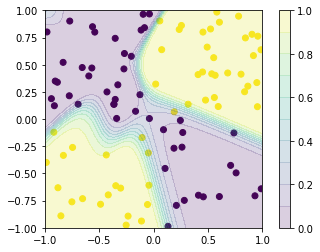

In [6]:
# training
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = np.prod(x, axis=1) > 0
    return x, labels.reshape(-1, 1)


x_train, y_train = create_toy_data()
model = ClassificationNetwork(2, 4, 1)
optimizer = nn.optimizer.Adam(model.parameter, 1e-3)
history = []
for i in range(10000):
    model.clear()
    logit = model(x_train)
    log_likelihood = -nn.loss.sigmoid_cross_entropy(logit, y_train).sum()
    optimizer.maximize(log_likelihood)
    history.append(log_likelihood.value)
    
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("Log Likelihood")
plt.show()
    
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
y = nn.sigmoid(model(x)).value.reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.show()

### 5.3.1 误差函数导数的计算

现在，我们推导适用于有任意前馈拓扑结构，任意可微的非线性激活函数，以及一大类的误差函数的一般神经网络的反向传播算法。推导的结果将会使用有一个单层的sigmoid隐含单元及平方和误差函数的简单层次网络结构来阐述。
需要实际应用中的误差函数，如：独立同分布数据集上定义的最大似然，由每一项对应于训练集的一个数据点的求和式组成：
$ E(w) = \sum\limits_{n=1}^NE_n(w) \tag{5.44} $
这里，我们要考虑计算误差函数中$ \nabla E_n(w) $这样的项的问题。这可以直接使用顺序优化的方法计算，或使用批处理方法在训练集上进行累加。
首先，考虑输出$ y_k $是输入$ x_i $的线性组合的简单线性模型，即
$ y_k = \sum\limits_iw_{ki}x_i \tag{5.45} $
对于特定的输入模式$ n $，误差函数具有
$ E_n = \frac{1}{2}\sum\limits_k(y_{nk} - t_{nk})^2 \tag{5.46} $
的形式，其中$ y_{nk} = y_k(x_n,w) $。这个误差函数关于权值$ w_{ji} $的梯度由
$ \frac{\partial E_n}{\partial w_{ji}} = (y_{nj} - t_{nj})x_{ni} \tag{5.47} $
给出，它可以解释成与链接$ w_{ji} $的输出端相关联的“误差信号”$ y_{nj} − t_{nj} $和与链接的输入端相关联的 变量$ x_{ni} $的乘积的“局部”计算。在4.3.2节中，我们看到logistic sigmoid激活函数与交叉熵误差函数，以及softmax激活函数与与之对应的交叉熵误差函数，也会产生同样的结果。这里，我们会看到这个简单结果如何扩展到更复杂的多层前馈神经网络中。
在一个广义的前馈神经网络中，每个单元都会计算输入的加权和：
$ a_j = \sum\limits_iw_{ji}z_i \tag{5.48} $
其中$ z_i $是单元的激活或输入，它向单元$ j $发送连接，$ w_{ji} $是这个连接的权值。在5.1节中，我们看到偏置可以通过引入一个额外的激活恒为$ +1 $单元或输入来集成到这个求和公式中。于是我们不需要显式的来处理偏置。式（5.48）的求和项是通过非线性激活函数$ h(\dot) $变换得到的单元$ j $的激活$ z_j $，形式为
$ z_j = h(a_j) \tag{5.49} $
注意，式（5.48）的求和项中的一个或几个变量$ z_i $可以是输入，同样的，式（5.49）中的单元$ j $可以是输出。
对于训练集中的每个模式，我们假定给网络提供了对应的输入向量，并反复应用式（5.48）（5.49）计算了网络中所有隐藏和输出单元的激活。由于这可以被看做网络中的一个向前流动的信息流，所以通常被称为正向传播（forward propagation）。
现在考虑计算$ E_n $关于权值$ w_{ji} $的导数。各个单元的输出会依赖于某个特定的输入模式$ n $。但是，为了保持记号的简洁，我们将省略网络变量中的下标$ n $。首先，我们注意到$ E_n $只通过单元$ j $的求和之后的输入$ a_j $对权值$ w_{ji} $产生依赖。因此，我们可以应用偏导的链式法则，得到
$ \frac{\partial E_n}{\partial w_{ji}} = \frac{\partial E_n}{\partial a_j}\frac{\partial a_j}{\partial w_{ji}} \tag{5.50} $
现在，我们介绍一个非常有用的记号
$ \delta_j \equiv \frac{\partial E_n}{\partial a_j} \tag{5.51} $
其中$ \delta $通常被用来标记误差，原因我们稍后会看到。使用式（5.48）我们可以写成
$ \frac{\partial a_j}{\partial w_{ji}} = z_i \tag{5.52} $
把式（5.51）（5.52）代入式（5.50），可以得到
$ \frac{\partial E_n}{\partial w_{ji}} = \delta_jz_i \tag{5.53} $
式（5.53）告诉我们，要求的导数可以简单的通过将权值输出端单元的$ \delta $的值乘以权值输入端的$ z $的值的方式得到（对于偏置来说$ z = 1 $）。注意，这与本节开始时讨论的简单线性模型具有相同的形式。因此，为了计算导数，我们只需要计算网络中每个隐藏和输出结点的$ \delta_j $的值，然后应用式（5.53）即可。
正如我们已经看到的那样，只要我们使用标准链接作为输出单元的激活函数，那么对于输出单元，就有
$ \delta_k = y_k - t_k \tag{5.54} $
为了计算隐藏单元的$ \delta $，我们再一次使用偏导数的链式法则：
$ \delta_j \equiv \frac{\partial E_n}{\partial a_j} = \sum\limits_k\frac{\partial E_n}{\partial a_k}\frac{\partial a_k}{\partial a_j} \tag{5.55} $
其中求和式的作用对象是单元$ j $发送链接的所有单元$ k $。图5.7阐释了单元的排列和权值。

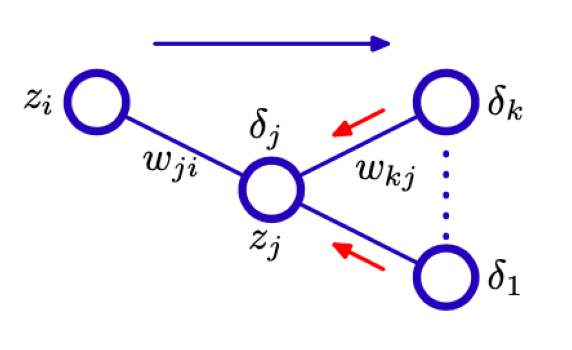

In [30]:
# 图5.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.7.png')
plt.axis('off')
ax.imshow(d)

注意，标记为$ k $的单元，可以包含其他的隐藏单元和（或）输出单元。在给出式（5.55）时，我们使用了这个事实:$ a_j $的改变所造成的误差函数的改变的唯一来源是变量$ a_k $的改变。如果我们把式（5.51）给出的$ \delta $的定义代入式（5.55），然后使用式（5.48）（5.49），就得到了
$ \delta_j = h'(a_j)\sum\limits_kw_{kj}\delta_k \tag{5.56} $
这个反向传播（backpropagation）公式。这表明，一个特定的隐藏单元的$ \delta $值可以通过将网络中更高层单元的$ delta $进行反向传播来得到。如图5.7所示。注意，式（5.56）中的求和项是由$ w_{kj} $的第一个下标得到的（对应于信息在网络中的反向传播），而在正向传播方程（5.10）中，求和过程针对的是第二个下标。由于我们已经知道了输出单元的$ \delta $，所以通过递归地应用式（5.56），我们可以计算前馈网络中所有隐藏单元的$ \delta $值，无论它的拓扑结构是什么样的。
于是，反向传播算法可以总结如下：
- 对于网络的一个输入向量$ x_n $，使用式（5.48）（5.49）进行正向传播，找到所有隐含单元和输出单元的激活。
- 使用式（5.54）计算所有输出单元的$ \delta_k $。
- 使用式（5.56）反向传播$ \delta $，获得网络中所有隐含单元的$ \delta_j $。
- 使用式（5.53）计算导数。
对于批处理方法，总误差函数$ E $的导数可以通过对于训练集里的每个模式，重复上面的步骤，然后对所有的模式求和：
$ \frac{\partial E}{\partial w_{ji}} = \sum\limits_n\frac{\partial E_n}{\partial w_{ji}} \tag{5.57} $
来获得。在上面的推导中，我们隐式地假设网络中的每个隐藏单元或输入单元都有相同的激活函数$ h(\dot) $。然而，这只需记录哪个单元具有哪种形式的$ h(\dot) $就可以把这个推导推广到不同的单元有各自的激活函数的情况。




### 5.3.2 一个简单的例子

上面的推导过程适用于一般的形式的误差函数，激活函数以及网络拓扑。为了阐述如何应用这个算法，我们来考虑一个特别的例子。我们选择了一个既简单又在实际应用中非常重要的例子，且在神经网络文献中许多应用都使用的这种类型的网络。具体地，我们会考虑图5.1展示的具有平方和误差，输出单元有线性激活函数即$ y_k = a_k $，隐藏单元具有由
$ h(a) \equiv tanh(a) \tag{5.58} $
给出的logistic sigmoid激活函数的二层网络。其中
$ tanh(a) = \frac{e^a - e^{-a}}{e^a + e^{-a}} \tag{5.59} $
这个函数的一个很有用的性质是它的导数可以表示为相当简单的形式。
$ h'(a) = 1 - h(a)^2 \tag{5.60} $
我们也考虑标准平方和误差函数，那么模式$ n $的误差由
$ E_n = \frac{1}{2}\sum\limits_{k=1}^K(y_k - t_k)^2 \tag{5.62} $
给出。其中对于一个特定的输入模式$ x_n $，$ y_k $是输出单元$ k $的激活，$ t_k $是对应的目标。
对于训练集中的每个模式，首先我们使用
$ \begin{eqnarray} a_j = \sum\limits_{i=0}^Dw_{ji}^{(1)}x_i \tag{5.62} \\ z_j = tanh(a_j) \tag{5.63} \\ y_k = \sum\limits_{j=0}^Mw_{kj}^{(2)}z_j \tag{5.64} \end{eqnarray} $
来进行前向传播。然后使用
$ \delta_k = y_k - t_k \tag{5.65} $
来计算每个输出的$ \delta $。接下来我们再利用获得的这些$ \delta $结合
$ \delta_j = (1-z_j^2)\sum\limits_{k=1}^Kw_{kj}\delta_k \tag{5.66} $
来反向传播。 最终，第一层和第二层的关于权值的导数为：
$ \frac{\partial E_n}{\partial w_{ji}^{(1)}} = \delta_jx_i , \frac{\partial E_n}{\partial w_{kj}^{(2)}} = \delta_kz_j \tag{5.67} $



### 5.3.3 反向传播的效率

反向传播的一个重要的方面是它的计算效率。为了理解这一点，让我们考察计算误差函数的导数需要的次数与网络中权值与偏置的总量$ W $之间的关系。误差函数单次计算（对于给定输入模式），当$ W $充分大时，需要$ O(W) $次操作。这是因为除非网络的连接十分稀疏，否则权值的数量通常大大超过单元的数量，所以正向传播的计算复杂度主要取决于公式（5.48)的求和项的计算，而激活函数的计算就相对耗时较少。式（5.48）的求和项中的每一项需要一次乘法和一次加法，从而整体的计算开销为$ O(W) $。
反向传播计算误差函数导数的另一种方法是使用有限差。这可以通过让每个权值有一个扰动，然后使用
$ \frac{\partial E_n}{\partial w_{ji}} = \frac{E_n(w_{ji} + \epsilon) - E_n(w_{ji})}{\epsilon} + O(\epsilon) \tag{5.68} $
来近似导数，其中$ \epsilon \ll 1 $。在软件模拟中，通过让$ \epsilon $变小，可以提高导数近似的精度，直到数值下溢问题出现。使用形式为
$ \frac{\partial E_n}{\partial w_{ji}} = \frac{E_n(w_{ji} + \epsilon) - E_n(w_{ji} - \epsilon)}{2\epsilon} + O(\epsilon^2) \tag{5.69} $
的对称的中心差（central difference）可以极大的提高有限差的精度。在这种情况下，$ O(\epsilon) $修正取消了，这可以通过式（5.69）右手边的泰勒展开来证明，但是它产生的修正项$ O(\epsilon^2) $。然而，与式（5.68）相比，计算步骤数大约变成了二倍。
计算数值导数的最主要问题是计算复杂度为$ O(W) $这一理想性质不成立。每次正向传播都需要$ O(W) $步，而网络中有$ W $个权值都需要单独加扰动，因此整体的时间复杂度为$ O(W^2) $。
然而，由于将反向传播算法计算的导数与使用中心差计算的导数进行对比，可以有效地检查反向传播算法的执行正确性，所以数值导数的方法在实际应用中具有重要的作用。在实际应用中，当训练一个网络时，因为反向传播算法具有最高的精度和效率，所以因该使用它来计算导数。但是，还需要使用式（5.69）的数值导数的结果与之对比，来检查执行的正确性。



### 5.3.4 Jacobian矩阵

我们已经看到了误差函数关于权值的导数是如何通过网络中的误差反向传播来获得的。反向传播技术也可以用来计算其它类型的导数。这里，我们考虑元素的值是网络输出关于输入的导数的Jacobian矩阵的计算
$ J_{ki} \equiv \frac{\partial y_k}{\partial x_i} \tag{5.70} $
其中，每个这样的导数计算时，其它的输入都是固定的。Jacobian矩阵在由许多不同模块构建的系统中很有用，如图5.8所示。
 

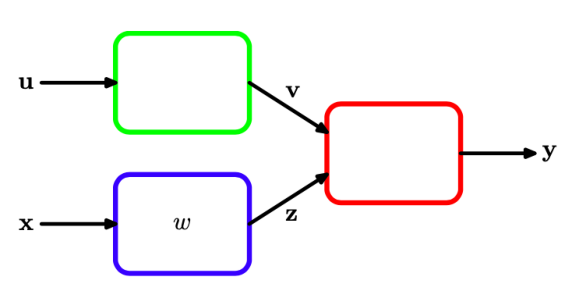

In [31]:
# 图5.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.8.png')
plt.axis('off')
ax.imshow(d)

每个模块可以由一个固定的或可调节的函数构成，它可以是线性的或非线性的，只要可微即可。假设我们想关于图5.8中的参数$ w $，最小化误差函数$ E $。误差函数的导数由
$ \frac{\partial E}{\partial w} = \sum\limits_{k,j}\frac{\partial E}{\partial y_k}\frac{\partial y_k}{\partial z_j}\frac{\partial z_j}{\partial w} \tag{5.71} $
其中，图5.8中的红色模块的Jacobian矩阵出现在中间项。
应为Jacobian矩阵提供了输出对每个输入变量的局部灵敏度的度量，所以它也允许与输入关联的任意已知的误差$ \Delta x_i $在训练过的网络中传播，从而估计它们对于输出误差$ \Delta y_k $的贡献。它们之前有一个只要$ \vert \Delta x_i \vert $够小，就成立的关系：
$ \Delta y_k \simeq \sum\limits_i\frac{\partial y_k}{\partial x_i}\Delta x_i \tag{5.72} $
通常，训练过的神经网络表示的网络映射是非线性的，所以Jacobian矩阵的元素不会是常数，而是依赖于具体使用的输入向量。因此式（5.72）只在输入有较小的扰动时成立，而且对于每个新的输入变量，Jacobian矩阵需要重新计算。
Jacobian矩阵可以使用与之前推导误差函数关于权值的导数类似的方法来使用反向传播来计算得到。我们以把元素$ J_{ki} $写成
$ \begin{eqnarray} J_{ki} = \frac{\partial y_k}{\partial x_i} &=& \sum\limits_j\frac{\partial y_k}{\partial a_j}\frac{\partial a_j}{\partial x_i} \ &=& \sum\limits_jw_{ji}\frac{\partial y_k}{\partial a_j} \tag{5.73} \end{eqnarray} $
的形式来开始，其中我们使用了式（5.48）。式（5.73）中的求和项作用于所有单元$ i $发送连接的单元$ j $上 （如：之前讨论的层次拓扑结构中的第一个隐藏层的所有单元）。我们现在一个递归的反向传播公式来确定导数$ \partial y_k/\partial a_j $
$ \begin{eqnarray} \frac{\partial y_k}{\partial a_j} &=& \sum\limits_l \frac{\partial y_k}{\partial a_l}\frac{\partial a_l}{\partial a_j} \ &=& h'(a_j)\sum\limits_l w_{lj}\frac{\partial y_k}{\partial a_l} \tag{5.74} \end{eqnarray} $
其中求和的对象是所有单元$ j $发送连接的单元$ l $（对应于$ w_{lj} $的第一个下标）。与之前一样，我们 使用了式（5.48）和式（5.49）。这个反向传播开始于导数可以直接从输出单元激活函数的函数形式中得到的输出单元。例如：如果对于每个输出单元，我们都有各自的sigmoid函数，那么
$ \frac{\partial y_k}{\partial a_j} = \delta_{kj}\sigma '(a_j) \tag{5.75} $
其中，对于softmax输出我们有
$ \frac{\partial y_k}{\partial a_j} = \delta_{kj}y_k - y_ky_j \tag{5.76} $
我们可以将计算Jacobian矩阵的方法总结如下。将输入空间中要寻找Jacobian矩阵的点映射成一个输入向量，将这个输入向量作为网络的输入，使用通常的正向传播方法，得到网络的所有隐藏单元和输出单元的激活。然后，对于Jacobian矩阵的每一行$ k $（对应于输出单元$ k $），使用递归关系（5.74）进行反向传播。对于网络中所有的隐藏结点，以式（5.75）和式（5.76）开始我们的反向传播。最后，使用式（5.73）进行输入单元的反向传播。Jacobian矩阵的另一种计算方法是可以使用与这里给出的反向传播算法相类似的方式推导出来的正向传播算法。
与之前一样，这个算法可以通过
$ \frac{\partial y_k}{\partial x_i} = \frac{y_k(x_i + \epsilon) - y_k(x_i - \epsilon)}{2\epsilon} + O(\epsilon^2) \tag{5.77} $
数值导数的方法检验正确性。对于一个有着$ D $个输入的网络来说，这种方法需要$ 2D $次正向传播。



## 5.4 Hessian矩阵

我们已经说明了如何使用反向传播的方法来得到误差函数关于网络权值的一阶导数。反向传播也可以用来计算误差函数的二阶导数，形式为：
$ \frac{\partial^2 E}{\partial w_{ji}\partial w_{lk}} \tag{5.78} $
。注意，有时把所有的权值和偏置参数看成一个向量$ w $的元素$ w_i $更方便，此时二阶导数 组成了Hessian矩阵$ H $的元素$ H_{ij} i,j \in {1,...,W} $，其中$ W $是权值和偏置的总数。Hessian矩 阵在神经网络计算的许多方面都有着重要的作用，其中包括：
1.	一些用来训练神经网络的非线性最优化算法是基于误差曲面的由Hessian矩阵控制的二阶性质的(Bishop and Nabney, 2008)。
2.	对于训练数据的微小改变，Hessian矩阵构成了快速重新训练前馈网络的算法的基础(Bishop, 1991)
3.	Hessian矩阵的逆矩阵用来鉴别神经网络中最不重要的权值，这是网络“剪枝”算法的一部分(LeCun et al., 1990)
4.	Hessian矩阵是贝叶斯神经网络（见5.7节）的拉普拉斯近似的核心。它的逆矩阵可以用来确定训练过的神经网络的预测分布，它的特征值确定了超参数的值，它的行列式可以用来计算模型证据
神经网络的Hessian矩阵有很多近似计算方法。然而，通过反向传播方法的一个扩展来精确的计算Hessian矩阵。
对于Hessian矩阵的很多应用来说，一个需要重点考虑的问题是计算效率。如果网络中有$ W $个参数（权值和偏置），那么Hessian矩阵的维度为$ W \times W $，因此对于数据集里的每个模式来说，计算Hessian矩阵的计算量为$ O(W^2) $。正如我们将看到的那样，计算Hessian矩阵的高效方法的计算复杂度确实是$ O(W^2) $。



### 5.4.1 对角近似

上面讨论的Hessian矩阵的一些应用需要求出Hessian矩阵的逆矩阵，而不是Hessian矩阵本身。因此，我们对Hessian矩阵的对角化近似比较感兴趣。换句话说，就是把非对角线上的元素置为零，因为这样做之后，矩阵的逆很容易计算。与之前一样，我们考虑由一系列项的求和项组成的误差函数，每一项对应于数据集里的一个模式，即$ E = \sum_n E_n $。这样，Hessian矩阵可以通过每次考虑一个模式然后对所有模式求和的方法得到。根据式（5.48），对于模式$ n $，Hessian矩阵的对角线元素可以写成
$ \frac{\partial^2 E_n}{\partial w_{ji}^2} = \frac{\partial^2 E_n}{\partial a_j^2}z_j^2 \tag{5.79} $
使用式（5.48）（5.49），式（5.79）右手边的二阶导数可以通过递归地使用微分的链式法则来给出形式为
$ \frac{\partial^2 E_n}{\partial a_j^2} = h'(a_j)^2\sum\limits_k\sum\limits_{k'}w_{kj}w_{k'j}\frac{\partial^2E_n}{\partial a_k\partial a_{k'}} + h''(a_j)\sum\limits_kw_{kj}\frac{\partial E_n}{\partial a_k} \tag{5.80} $
的反向传播方程来获得。如果我们忽略二阶导数中非对角线元素，那么我们有(Becker and LeCun, 1989; LeCun et al., 1990)
$ \frac{\partial^2 E_n}{\partial a_j^2} = h'(a_j)^2\sum\limits_kw_{kj}^2\frac{\partial^2E_n}{\partial a_k^2} + h''(a_j)\sum\limits_kw_{kj}\frac{\partial E_n}{\partial a_k} \tag{5.81} $
注意，计算这个近似所需的计算步骤数为$ O(W) $，其中$ W $是网络中权值和偏置的总数。对比全Hessian矩阵的计算步骤数$ O(W^2) $。
Ricotti et al.(1998)也使用了Hessian矩阵的对角近似，但是他们在计算$ \partial^2 E_n/\partial a_j^2 $时保留了所有项，从而得到了对角项的精确的表达式。注意，这样就不再具有$ O(W) $的计算复杂度。然而，对角近似的主要问题是在实际应用中Hessian矩阵通常是强烈非对角化的，所以为了计算方便而采取的这些近似手段必须非常谨慎。



### 5.4.2 外积近似

当神经网络应用于回归问题时，通常使用形式为
$ E = \frac{1}{2}\sum\limits_{n=1}^N(y_n - t_n)^2 \tag{5.82} $
的平方和误差函数。其中为了记号的简洁，我们考虑单一输出的情形（推广到多个输出也是很直接的）。这样，我们可以把Hessian矩阵写成
$ H = \nabla\nabla E = \sum\limits_{n=1}^N\nabla y_n\left(\nabla y_n\right)^T + \sum\limits_{n=1}^N(y_n - t_n)\nabla\nabla y_n \tag{5.83} $
的形式。如果网络已经在数据集上训练过，且输出$ y_n $恰好非常接近$ t_n $，那么式（5.83）的第二项会很小，可以被忽略。然而，更一般的情况下，忽略这一项可能更合适。这是因为：回忆一下，根据1.5.5节的讨论，最小化平方和损失的最优函数是目标数据的条件平均。这样，$ (y_n − t_n) $是 一个均值为0的随机变量。如果我们假设它的值与式（5.83）右侧的二阶导数项无关，那么在对于$ n $的求和项中，整个项的平均值将会等于零。
通过忽略式（5.83）的第二项，我们就得到了Levenberg-Marquardt近似，或称为外积近似（outer product approximation）（因为此时Hessian矩阵由向量外积的求和构造出来）由
$ H \simeq \sum\limits_{n=1}^Nb_nb_n^T \tag{5.84} $
给出，其中因为输出单元的激活函数是恒等函数，所以$ b_n = \nabla y_n = \nabla a_n $。Hessian矩阵外积近似的计算是很容易的，因为它只涉及到误差函数的一阶导数，这可以通过使用标准的反向传播算法在$ O(W) $个步骤内高效地求出。通过简单的乘法，矩阵的元素可以在$ O(W^2) $个步骤内计算出。需要特别强调的一点是，这种近似只在网络被恰当地训练时才成立，对于一个一般的网络映射，式（5.83）的右侧的二阶导数项通常不能忽略。
在误差函数为交叉熵误差函数，输出单元激活函数为logistic sigmoid函数的神经网络中，对应的近似为
$ H \simeq \sum\limits_{n=1}^Ny_n(1-y_n)b_nb_n^T \tag{5.85} $
对于具有softmax输出激活函数的多类别网络可以得到类似的结果。



### 5.4.3 Hesian矩阵的逆矩阵

我们可以使用外积近似来高效的计算Hessian矩阵的逆（Hassibi and Stork, 1993）。首先，我们把外积近似写成矩阵形式：
$ H_N = \sum\limits_{n=1}^Nb_nb_n^T \tag{5.86} $
其中$ b_n \equiv \nabla_na_n $数据点$ n $产生的输出单元激活对梯度的贡献。现在，我们推导一个一次使用一个数据点来顺序构造Hessian矩阵的过程。假设，我们已经由开始的$ L $个数据点得到Hessian的逆。将第$ L + 1 $个数据点的贡献单独写出来，得到
$ H_{L + 1} = H_L + b_{L+1}b_{L+1}^T \tag{5.87} $
为了计算Hessian的逆，现在我们考虑矩阵恒等式：
$ (M+vv^T)^{-1} = M^{-1} - \frac({M^{-1}v)(v^TM^{-1})}{1 + v^TM^{-1}v} \tag{5.88} $
这是一个Woodbury恒等式的一个特例（C.7）。如果我们令$ H_L = M $，且$ b_L + 1 = v $，得到
$ H_{L+1}^{-1} = H_L^{-1} - \frac{H_L^{-1}b_{L+1}b_{L+1}^TH_L^{-1}}{1+b_{L+1}^TH_L^{-1}b_{L+1}} \tag{5.89} $
这种方法中，数据点被依次使用，直到$ L + 1 = N $整个数据集都被处理。于是，这个结果表示一个通过扫描数据集一次来计算Hessian矩阵的逆矩阵的算法。最开始的矩阵$ H_0 $被设置为$ \alpha I $，其中$ \alpha $是一个较小的量，从而算法实际找的是$ H + \alpha I $的逆矩阵。结果对于$ \alpha $的精确值不是特别敏感。可以很直接的将这个算法推广到多于一个输出的情形。
这里，我们注意到，有时Hessian矩阵可以作为网络训练算法的一部分被间接计算出来。特别地，拟牛顿非线性优化算法在训练过程中逐步建立起Hessian矩阵的逆的近似。关于这种算法的详细讨论，可以参考Bishop and Nabney(2008)。



### 5.4.4 有限差

与误差函数的一阶导数情况一样，我们可以使用有限差来得到精度受数值计算的精度限制的二阶导数。如果我们对每对可能的权值施加一个扰动，那么我们得到
$ \begin{eqnarray} \frac{\partial^2 E}{\partial w_{ji}\partial w_{lk}} = \frac{1}{4\epsilon^2}{E(w_{ji} + \epsilon, w_{lk} + \epsilon) - E(w_{ji} + \epsilon, w_{lk} - \epsilon) \ -E(w_{ji} - \epsilon, w_{lk} + \epsilon) + E(w_{ji} - \epsilon, w_{lk} - \epsilon)} + O(\epsilon^2) \tag{5.90} \end{eqnarray} $
同样的，通过使用对称的中心差，我们确保残留误差是$ O(\epsilon^2) $而不是$ O(\epsilon) $。因为Hessian矩阵有$ W^2 $个元素，且每个元素的计算四次复杂度为$ O(W) $的前向传播（每个模式）。因此我们看到这种方法计算完整的Hessian矩阵需要$ O(W^3) $次操 作。所以，虽然在实际应用中它对于验证反向传播算法的正确性很有用，但是这个方法的计算性质很差。
一个更加高效的数值导数的方法是将中心差应用于可以通过反向传播方法计算的一阶导数。得到
$$
\frac{\partial^{2} E}{\partial w_{j i} \partial w_{l k}}=\frac{1}{2 \epsilon}\left\{\frac{\partial E}{\partial w_{j i}}\left(w_{l k}+\epsilon\right)-\frac{\partial E}{\partial w_{j i}}\left(w_{l k}-\epsilon\right)\right\}+O\left(\epsilon^{2}\right)
\tag{5.91} $$
因为只有$ W $个权值需要加上扰动，且梯度可以通过$ O(W) $次计算得到，所以这种方法可以通过$ O(W^2) $次操作得到Hessian矩阵。



### 5.4.5 Hessian矩阵的精确计算

目前为止，我们已经考察了各种计算Hessian矩阵或逆矩阵的近似方法。对于一个任意的前馈拓扑结构的网络，Hessian矩阵也可以使用反向传播算法计算一阶导数的推广来精确的计算。这同时也保留了计算一阶导数的方法的许多良好的性质，包括计算效率(Bishop, 1991; Bishop, 1992)。这种方法可以应用于任何表示网络输出的的可微的误差函数，及任何具有可微的激活函数的神经网络。计算Hessian矩阵的复杂度为$ O(W^2) $。类似的算法也可以参考Buntine and Weigend(1993)。
这里我们考虑具有两层权值（待求的方程很容易推导）的网络。我们将使用下标$ i, i' $表示输入，用下标$ j, j' $表示隐藏单元，用下标$ k, k' $表示输出。首先定义
$ \delta_k = \frac{\partial E_n}{\partial a_k} , M_{kk'} \equiv \frac{\partial^2 E_n}{\partial a_k\partial a_{k'}} \tag{5.92} $
其中$ E_n $表示数据点$ n $对误差的贡献。这个网络的Hessian矩阵可以被看成三个独立的项：
1.	两个权值都在第二层
$ \frac{\partial^2 E_n}{\partial w_{kj}^{(2)}\partial w_{k'j'}^{(2)}} = z_jz_{j'}M_{kk'} \tag{5.93} $
2.	两个权值都在第一层
$ \begin{eqnarray} \frac{\partial^2 E_n}{\partial w_{ji}^{(1)}\partial w_{j'i'}^{(1)}} = x_ix_{i'}h''(a_{j'})I_{jj'}\sum\limits_kw_{kj'}^{(2)}\delta_k \
o	x_ix_{i'}h'(a_{j'})h'(a_j)\sum\limits_k\sum\limits_{k'}w_{k'j'}^{(2)}w_{kj}^{(2)}M_{kk'} \tag{5.94} \end{eqnarray} $
3.	权值分别在两层$$
\frac{\partial^{2} E_{n}}{\partial w_{j i}^{(1)} \partial w_{k j^{\prime}}^{(2)}}=x_{i} h^{\prime}\left(a_{j}\right)\left\{\delta_{k} I_{j^{\prime} j}+z_{j^{\prime}} \sum_{k^{\prime}} w_{k^{\prime} j}^{(2)} M_{k k^{\prime}}\right\}
 \tag{5.95} $$
这里$ I_{jj'} $是单位矩阵的第$ j, j' $个元素。如果权值中的一个或两个是偏置项，那么只需将激活设为1就可以得到对应的表达式。很容易将这个结果推广到网络包含跨层连接的情形。



### 5.4.6 Hessian矩阵的快速乘法

对于Hessian矩阵的许多应用来说，我们感兴趣的不是Hessian矩阵$ H $本身，而是$ H $与某些向量$ v $的乘积。我们已经知道Hessian矩阵的计算需要$ O(W^2) $次操作，所需的存储空间也是$ O(W^2) $。但是，我们想要计算的向量$ v^TH $只有$ W $个元素。因此，我们可以不把计算Hessian矩阵当成一个中间的步骤，而是尝试寻找一种只需$ O(W) $次操作的高效方法来直接计算$ v^TH $。
为了达到这个目的，我们首先注意到
$ v^TH = v^T\nabla(\nabla E) \tag{5.96} $
其中$ \nabla $表示权空间的梯度。然后，我们可以写下计算$ \nabla E $的标准正向传播和反向传播的方程，然后对这些方程应用式（5.96）得到一组计算$ v^TH $的正向传播和反向传播的方程（Møller, 1993; Pearlmutter, 1994）。这对应于将微分操作$ v^T\nabla $作用于原始的正向传播和反向传播的方程。Pearlmutter(1994)使用记号$ R\{ .\} $表示操作符$ v^T\nabla $，我们将遵从这个惯例。分析过程很直接，我们会使用微积分的通用规则，以及
$ R\{w\} = v \tag{5.97} $
这个结果。
我们会使用一个简单的例子来很好的说明这种技术。同样的，我们使用图5.1展示的两层网络，及线性的输出单元和平方和误差函数。与之前一样，我们考虑数据集里的一个模式对于误差函数的贡献。这样，我们所要求的向量可以通过每个模式各自的贡献然后求和得到。对于两层神经网络，正向传播方程由
$ \begin{eqnarray} a_j &=& \sum\limits_i w_{ji}x_i \tag{5.98} \\ z_j &=& h(a_j) \tag{5.99} \\ y_k &=& \sum\limits_j w_{kj}z_j \tag{5.100} \end{eqnarray} $
给出。在这些方程上运用$ R\{.\} $，得到一组形式为
$ \begin{eqnarray} R\{a_j\} &=& \sum\limits_i v_{ji}x_i \tag{5.101} \\ R\{z_j\} &=& h'(a_j)R{a_j} \tag{5.102} \\ R\{a_j\} &=& \sum\limits_jw_{kj}R{z_j} + \sum\limits_j v_{kj}z_j \tag{5.103} \end{eqnarray} $
其中，$ v_{ji} $是向量$ v $中对应于权值$ w_{ji} $的元素。$ R\{z_j\}, R\{a_j\}, R\{y_k\} $可以被看成新变量，它的值可以使用上面的方程得到。
由于我们正在考虑平方和误差函数，因此我们得到标准的反向传播表达式：
$ \begin{eqnarray} \delta_k &=& y_k - t_k \tag{5.104} \\ \delta_j &=& h'(a_j)\sum\limits_k w_{kj}\delta_k \tag{5.105} \end{eqnarray} $
同样的，在这些方程上运用$ R\{.\} $，得到一组形式为
$ \begin{eqnarray} R\{\delta_k\} &=& R\{y_k\} \tag{5.106} \\ R\{\delta_j\} &=& h''(a_j)R\{a_j\}\sum\limits_kw_{kj}\delta_k \ & & + h'(a_j)\sum\limits_kv_{kj}\delta_k + h'(a_j)\sum\limits_kw_{kj}R\{\delta_k\} \tag{5.107} \end{eqnarray} $
最后，我们有误差函数的一阶导数的方程：
$ \begin{eqnarray} \frac{\partial E}{\partial w_{kj}} &=& \delta_kz_j \tag{5.108} \\ \frac{\partial E}{\partial w_{ji}} &=& \delta_jx_i \tag{5.109} \end{eqnarray} $
在这些方程上运用$ R\{.\} $，得到$ v^TH $的元素的表达式：
$$
\begin{array}{c}
\mathcal{R}\left\{\frac{\partial E}{\partial w_{k j}}\right\}=\mathcal{R}\left\{\delta_{k}\right\} z_{j}+\delta_{k} \mathcal{R}\left\{z_{j}\right\} \\
\mathcal{R}\left\{\frac{\partial E}{\partial w_{j i}}\right\}=x_{i} \mathcal{R}\left\{\delta_{j}\right\}
\end{array}
\tag{5.110,5.111} $$
算法的实现涉及将新变量$ R{a_j}, R{z_j}, R{\delta_j} $引入到隐藏单元，并将$ R{\delta_k}, R{y_k} $引入到输出单元。对于每个输入模式，这些量的值可以使用之前的结果求出，$ v^TH $的元素的值由式（5.110）和式（5.111）给出。这种方法的一个好处是，计算$ v^TH $的方程与标准的正向传播和反向传播的方程相同，因此将现有软件扩展到能够计算这个乘积通常很容易。
如果必要的话，这个方法可以用来计算完整的Hessian矩阵。计算的方法为：将向量$ v $选为一系列的形如$ (0, 0,...,1,...,0) $的单位向量，每个单位向量选出Hessian矩阵中的一列。这种方法的数学形式与Bishop(1992)的反向传播算法等价，如5.4.5节所述。但是由于这种方法存在冗余计算，会损失一定的计算效率。



## 5.5 神经网络的正则化

神经网络的输入输出数量通常由数据集的维数确定，其中隐藏单元的数量$ M $是自由参数，可以调节来给出最好的预测表现。注意，这个$ M $控制了网络中参数（权值和偏置）的数量，所以我们期望最大似然能给出一个在欠拟和过拟之间做最好平衡的能得到最好泛化表现的$ M $的值。图5.9给出了不同的$ M $值对于正弦曲线回归问题的结果。

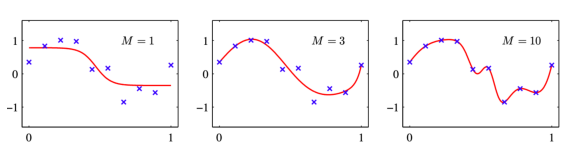

In [33]:
# 图5.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.9.png')
plt.axis('off')
ax.imshow(d)


然而，由于误差函数中存在局部极小值，所以泛化误差与$ M $的关系不是一个简单的函数关系，如图5.10所示。

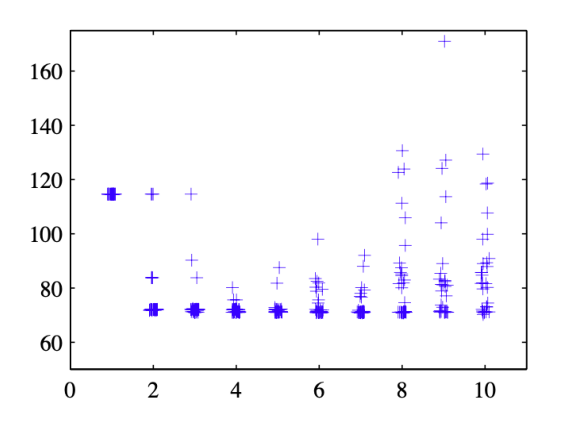

In [32]:
# 图5.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.10.png')
plt.axis('off')
ax.imshow(d)

这里，我们看到了对于不同的$ M $值，权值的多次随机初始化的影响。当$ M = 8 $的某个特定解在验证集上有整体最优表现。在实际应用中，选择$ M $的一种方法就是画一张类似图5.10的图，然后选择有最小验证集误差的具体的解。
然而，有一些其它的方法来控制神经网络模型的复杂度从而避免过拟问题。根据我们第1章中对多项式曲线拟合问题的讨论，我们知道，一种方法是选择一个相对较大的$ M $值，然后通过给误差函数加上一个正则化项来控制模型的复杂度。最简单的正则化项是二次的，给出了形式为
$ \tilde{E}(w) = E(w) + \frac{\lambda}{2}w^Tw \tag{5.112} $
的正则化的误差函数。这个正则化项也被称为权值衰减（weight decay），已经在第3章中详细的讨论过了。这样，模型复杂度可以通过选择正则化系数$ \lambda $来确定。正如我们之前看到的那样，正则化项可以表示为权向量$ w $上的0均值高斯先验分布的负对数。



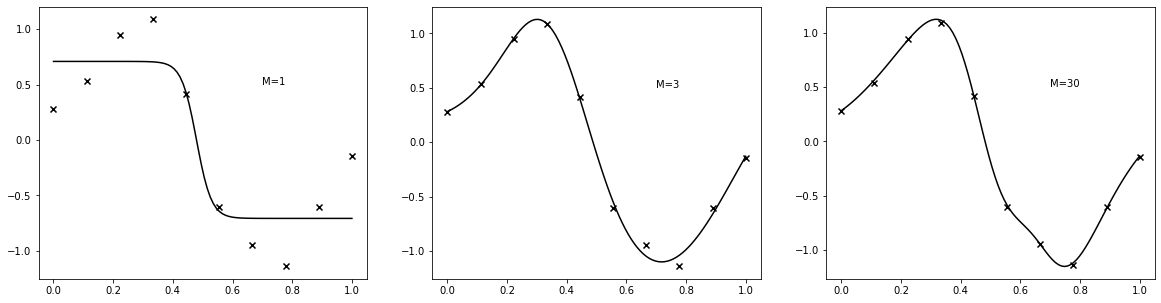

In [7]:
# 正则化
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))


x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None]

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = RegressionNetwork(1, m, 1)
    optimizer = nn.optimizer.Adam(model.parameter, 0.1)
    for j in range(10000):
        model.clear()
        y = model(x_train)
        optimizer.minimize(nn.square(y - y_train).sum())
        if j % 1000 == 0:
            optimizer.learning_rate *= 0.9
    y = model(x)
    plt.scatter(x_train.ravel(), y_train.ravel(), marker="x", color="k")
    plt.plot(x.ravel(), y.value.ravel(), color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

In [8]:
# model
class RegularizedRegressionNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter():
            self.w1 = nn.random.truncnormal(-2, 2, 1, (n_input, n_hidden))
            self.b1 = nn.zeros(n_hidden)
            self.w2 = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_output))
            self.b2 = nn.zeros(n_output)
        self.prior = nn.Gaussian(0, 1)

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        return h @ self.w2 + self.b2
    
    def log_prior(self):
        logp = 0
        for param in self.parameter.values():
            logp += self.prior.log_pdf(param)
        return logp

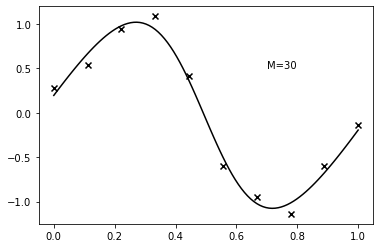

In [9]:
# training
model = RegularizedRegressionNetwork(1, 30, 1)
optimizer = nn.optimizer.Adam(model.parameter, 0.1)
for i in range(10000):
    model.clear()
    pred = model(x_train)
    log_posterior = -nn.square(pred - y_train).sum() + model.log_prior()
    optimizer.maximize(log_posterior)
    if i % 1000 == 0:
        optimizer.learning_rate *= 0.9
y = model(x).value
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

In [10]:
# data
def load_mnist():
    x, label = fetch_openml("mnist_784", return_X_y=True)
    x = x / np.max(x, axis=1, keepdims=True)
    x = x.reshape(-1, 28, 28, 1)
    label = label.astype(np.int)

    x_train, x_test, label_train, label_test = train_test_split(x, label, test_size=0.1)
    y_train = LabelBinarizer().fit_transform(label_train)
    return x_train, x_test, y_train, label_test
x_train, x_test, y_train, label_test = load_mnist()

In [11]:
# 训练
class ConvolutionalNeuralNetwork(nn.Network):
    
    def __init__(self):
        super().__init__()
        with self.set_parameter():
            self.conv1 = nn.image.Convolve2d(
                nn.random.truncnormal(-2, 2, 1, (5, 5, 1, 20)),
                stride=(1, 1), pad=(0, 0))
            self.b1 = nn.array([0.1] * 20)
            self.conv2 = nn.image.Convolve2d(
                nn.random.truncnormal(-2, 2, 1, (5, 5, 20, 20)),
                stride=(1, 1), pad=(0, 0))
            self.b2 = nn.array([0.1] * 20)
            self.w3 = nn.random.truncnormal(-2, 2, 1, (4 * 4 * 20, 100))
            self.b3 = nn.array([0.1] * 100)
            self.w4 = nn.random.truncnormal(-2, 2, 1, (100, 10))
            self.b4 = nn.array([0.1] * 10)
        
    def __call__(self, x):
        h = nn.relu(self.conv1(x) + self.b1)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))        
        h = nn.relu(self.conv2(h) + self.b2)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        h = h.reshape(-1, 4 * 4 * 20)
        h = nn.relu(h @ self.w3 + self.b3)
        return h @ self.w4 + self.b4

model = ConvolutionalNeuralNetwork()
optimizer = nn.optimizer.Adam(model.parameter, 1e-3)

while True:
    indices = np.random.permutation(len(x_train))
    for index in range(0, len(x_train), 50):
        model.clear()
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        logit = model(x_batch)
        log_likelihood = -nn.loss.softmax_cross_entropy(logit, y_batch).mean(0).sum()
        if optimizer.iter_count % 100 == 0:
            accuracy = accuracy_score(
                np.argmax(y_batch, axis=-1), np.argmax(logit.value, axis=-1)
            )
            print("step {:04d}".format(optimizer.iter_count), end=", ")
            print("accuracy {:.2f}".format(accuracy), end=", ")
            print("Log Likelihood {:g}".format(log_likelihood.value[0]))
        optimizer.maximize(log_likelihood)
        if optimizer.iter_count == 1000:
            break
    else:
        continue
    break

step 0000, accuracy 0.18, Log Likelihood -4709.11
step 0100, accuracy 0.54, Log Likelihood -356.598
step 0200, accuracy 0.66, Log Likelihood -278.894
step 0300, accuracy 0.64, Log Likelihood -306.104
step 0400, accuracy 0.80, Log Likelihood -69.2721
step 0500, accuracy 0.82, Log Likelihood -87.997
step 0600, accuracy 0.82, Log Likelihood -108.425
step 0700, accuracy 0.86, Log Likelihood -55.0875
step 0800, accuracy 0.84, Log Likelihood -81.9463
step 0900, accuracy 0.94, Log Likelihood -13.7418


In [12]:
print("accuracy (test):", accuracy_score(np.argmax(model(x_test).value, axis=-1), label_test))

accuracy (test): 0.8591428571428571


### 5.5.1 相容的高斯先验

式（5.112）给出的简单权值衰减的一个局限性是，它与网络映射的确定缩放性质不一致。为了说明这一点，考虑具有两层权值和线性输出单元的多层感知网络，它给出了从输入变量集合$ {x_i} $到输出变量集合$ {y_k} $的映射。第一个隐藏层的隐藏单元的激活的形式为
$ z_j = h\left(\sum\limits_i w_{ji}x_i + w_{j0}\right) \tag{5.113} $
输出单元的激活由
$ y_k = \sum\limits_j w_{kj}z_j + w_{k0} \tag{5.114} $
给出。假设我们对输入变量进行一个形式为
$ x_i \to \tilde{x}_i = ax_i + b \tag{5.115} $
线性变换。然后我们可以根据这个映射对网络，从输入单元到隐含层单元的权值和偏置也进行一个对应的形式为
$ \begin{eqnarray} w_{ji} \to \tilde{w}{ji} = \frac{1}{a}w{ji} \tag{5.116} \\ w_{j0} \to \tilde{w}{j0} = w{j0} - \frac{b}{a}\sum\limits_iw_{ji} \tag{5.117} \end{eqnarray} $
线性变换，使得网络给出的映射不变。同样的，网络的输出变量的线性变换
$ y_k \to \tilde{y}_k = cy_k + d \tag{5.118} $
可以通过对第二层的权值和偏置使用形式为
$ \begin{eqnarray} w_{kj} \to \tilde{w}{kj} &=& cw{kj} \tag{5.119} \\ w_{k0} \to \tilde{w}{k0} &=& cw{k0} + d \tag{5.120} \end{eqnarray} $
线性变换达到。
如果我们分别用原始数据、输入和（或）目标变量通过上面线性变换做变换后的数据来训练网络，那么一致性要求两个网络应该是等价的，差别仅在于上面给出的权值的线性变换。每个正则化项都应该与这个性质一致，否则模型就会倾向于选择某个解，而忽视某个等价的解。显然，简单的权值衰减（5.112）由于把所有的权值和偏置同等对待，因此不满足这个性质。
于是我们要寻找一个正则化项，它在线性变换（5.116）、（5.117）、（5.119）和（5.120）下具有不变性。这需要正则化项应该对于权值的重新缩放不变，对于偏置的平移不变。这样的正则化项由
$ \frac{\lambda_1}{2}\sum\limits_{w\in W_1} w^2 + \frac{\lambda_2}{2}\sum\limits_{w\in W_2} w^2 \tag{5.121} $
其中，$ W_1 $表示第一层的权值集合，$ W_2 $表示第二层的权值集合，且偏置被排除在求和式外。这个正则化项在正则化参数在使用$ \lambda_1 \to a^{1/2}\lambda_1, \lambda_2 \to c^{-1/2}\lambda_2 $进行缩放的权值变换下，正则项不会发生变化。
正则化项（5.121）对应
$ p(w|\alpha_1, \alpha_2) \propto exp\left(-\frac{\alpha_1}{2}\sum\limits_{w \in W_1}w^2 - \frac{\alpha_2}{2}\sum\limits_{w \in W_2}w^2\right) \tag{5.122} $
这样形式的先验。
注意，这种形式的先验因为偏置参数没有限制，所以是反常的（improper）（不能够被标准化）。使用反常先验使得对应的模型证据等于零，从而会给正则化系数的选择，或贝叶斯框架下的模型比较，造成很大的困难。因此，通常的做法是包含一个有着自己单独的一套超参数的偏置的先验（这就破坏了平移不变性）。为了说明四个超参数的效果，我们首先从先验中抽取样本，然后画出了对应的神经网络函数，如图5.11所示。

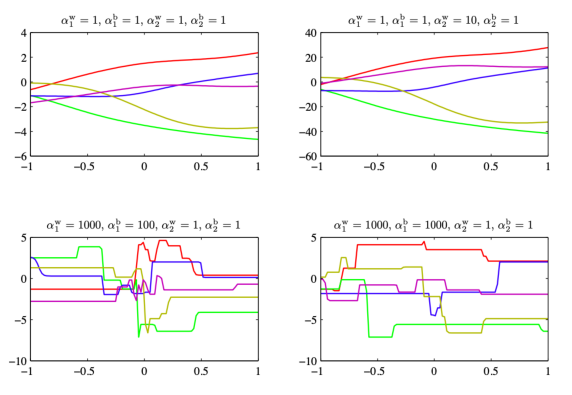

In [34]:
# 图5.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.11.png')
plt.axis('off')
ax.imshow(d)

更一般地，我们可以考虑权值被分为任意数量的组$ W_k $的情况下的先验，即
$ p(w) \propto exp\left(-\frac{1}{2}\sum\limits_k\alpha_k\Vert w \Vert_k^2\right) \tag{5.123} $
其中
$ \Vert w \Vert_k^2 = \sum\limits_{j \in W_k}w_j^2 \tag{5.124} $
作为这种形式的先验的一个特殊情况，如果我们将每个输入单元关联的权值设为一个分组，且关于对应的参数$ \alpha_k $最优化边缘似然函数，那么我们就得到了将在7.2.2节讨论的自动相关性确定（automatic relevance determination）的方法。




### 5.5.2 早停止

另一种控制网络的复杂度的正则化方法是早期停止（early stopping）。非线性网络模型的训练对应于关于训练数据集定义的误差函数的迭代减小。对于许多用于网络训练的最优化算法（如共轭梯度法），误差函数是一个关于迭代次数的非增函数。然而，在独立数据（通常被称为验证集）上测量的误差，通常会首先减小，然后由于模型开始过拟合而逐渐增大。于是，训练过程可以在关于验证集误差最小的点停止，如图5.12所示。

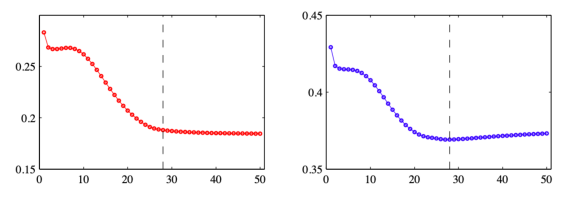

In [35]:
# 图5.12
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.12.png')
plt.axis('off')
ax.imshow(d)

这样就可以得到一个有着较好泛化性能的网络。

这种情况下，网络的行为有时可以通过网络的自由度有效数量来定量描述。自由度有效数量开始时很小，然后在训练过程中增长，对应于模型复杂度的持续增长。这样，在训练误差达到最小值之前停止训练就表示了一种限制模型复杂度的方式。

在二次误差函数的情况下，我们可以验证这种直观的描述，并说明早期停止的效果与使用简单的权值衰减的正则化项的效果类似。这可以通过图5.13来理解。图5.13中，权值空间的坐标轴已经进行了旋转，使得坐标轴平行于Hessian矩阵的特征向量。

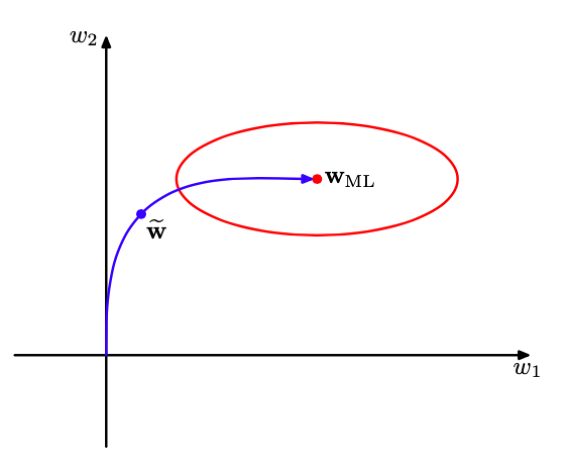

In [36]:
# 图5.13
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.13.png')
plt.axis('off')
ax.imshow(d)

在没有权值衰减的情况下，如果权向量开始于原点，且在训练过程中沿着局部负梯度向量确定的路径移动，那么权向量从最开始平行于$ w_2 $轴的位置，移动到大致对应$ \tilde{w} $的位置，然后向最小化误差函数的位置$ w_{ML} $移动。这可以从误差曲面和Hessian矩阵的特征值得出。于是，在点$ \tilde{w} $附近停止就类似于权值衰减。早期停止和权值衰减之间的关系可以定量描述，这说明了$ \tau\eta $（其中$ \tau $是迭代次数，$ \eta $是学习率参数）扮演了正则化参数$ \lambda $的倒数的角色。于是网络中有效参数的数量会在训练过程中增长。

### 5.5.3 不变性

在许多模式识别的应用中，对输入变量进行了一个或多个变换之后，预测不应该发生变化，或者说应该具有不变性（invariant）。如，在二维图像（如手写数字）的分类问题中，一个特定的图像的类别应该与图像的位置无关（平移不变性 translation invariance），也应该与图像的大小无关（缩放不变性 scale invariance）。这样的变换对于原始数据（用图像的每个像素的灰度值表示）产生了巨大的改变，但是分类系统还是应该给出同样的输出。同样的，在语音识别中，对于时间轴的微小的非线性变形（保持了时间顺序）不应该改变信号的意义。
如果有足够多的训练模式可用，那么可调节的模型（如神经网络）可以学习到不变性，至少可以近似地学习到。这涉及到在训练集里包含足够多的表示各种变换的效果的样本。因此，对于一个图像的平移不变性，训练集应该包含图像出现在多个不同位置的情况下的数据。
但是，如果训练样本数受限，或有多个不变性（变换的组合的数量随着变换的数量指数增长），那么这种方法就很不实用。于是，我们要寻找另外的方法来让可调节的模型具有所需的不变性。这些方法大致可以分为四类：
1.	通过复制训练模式，同时根据要求的不变性进行变换，对训练集进行扩展。如：在手写数字识别的例子中，我们可以将每个样本复制多次，并把它们移到不同的位置。
2.	为误差函数加上一个正则化项，用来惩罚当输入进行变换时，输出发生的改变。这引出了 5.5.4节讨论的切线传播（tangent propagation）方法。
3.	通过抽取在要求的变换下不发生改变的特征，不变性被整合到预处理过程中。任何后续的使用这些特征作为输入的回归或分类系统就会具有这些不变性。
4.	最后一种方法是把不变性的性质整合到神经网络的构建过程中（或对于相关向量机的方法整合到核函数中）。达到这个目的的一种方法是通过使用局部接收场和共享权值，正如5.5.6节在卷积神经网络中讨论的那样。
方法1通常实现起来相对简单，并且可以用来处理复杂的不变性，如图5.14所示。

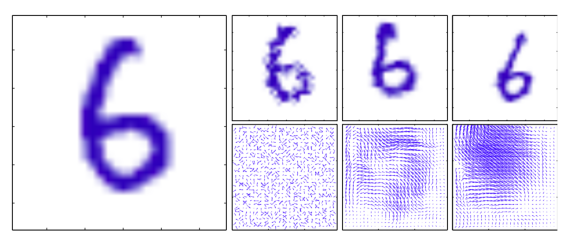

In [37]:
# 图5.14
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.14.png')
plt.axis('off')
ax.imshow(d)

对于顺序训练算法，可以在模型观测到输入模式之前，对每个输入模式进行变换，从而使得循环处理的模式，每次都会经过不同的变换（从一个适当的概率分布中抽取）。对于批处理方法，通过将每个数据点复制多次，然后独立地变换每个副本，来产生类似的效果。使用这些扩展后的数据虽然计算开销比较大，但是可以大幅提升泛化能力（Simard et al., 2003）。
方法2保持了数据集的不变性，而是给误差函数增加了一个正则化项。在5.5.5节，我们会看到方法1与方法2关系密切。
方法3的一个优点是，对于训练集里没有包含的变换，它可以正确的推算。然而，因为这种特征不仅要具有所需的不变性，还不能丢失对于判别很有帮助的信息，所以找到符合要求的人工设计的特征很困难。



### 5.5.4 切线传播

通过切线传播（tangent propagation）方法，我们可以使用正则化来让模型对于输入的变换具有不变性（Simard et al., 1992）。对于一个特定的输入向量$ x_n $，考虑变换产生的效果。假设变换是连续的（如平移或旋转，而不是镜像翻转），那么变换的模式会扫过$ D $维输入空间的一个流形$ M $。图5.15说明了$ D = 2 $的情形。



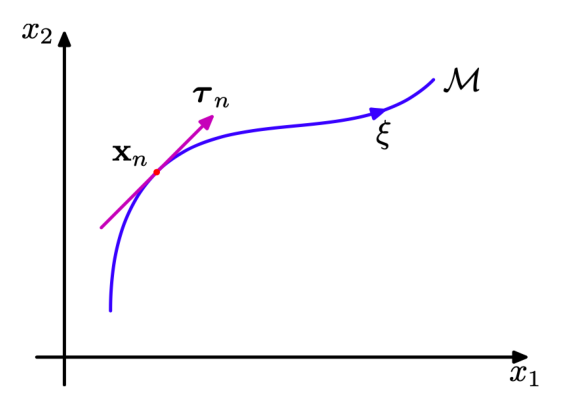

In [38]:
# 图5.15
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.15.png')
plt.axis('off')
ax.imshow(d)


假设变换由单一参数$ \xi $控制（如$ \xi $可能是旋转的角度）。那么被$ x_n $扫过的子空间$ M $是一维的，且以$ \xi $为参数。令这个变换作用于$ x_n $上产生的向量为$ s(x_x, \xi) $，且$ s(x,0) = x $。这样曲线$ M $的切线就由方向导数$ \tau = \partial x $给出，且点$ x_n $处的切线向量为：
$ \tau_n = \left.\frac{\partial s(x_n, \xi)}{\partial \xi}\vphantom{\Big|}\right| _{\xi = 0} \tag{5.125} $
对于输入向量进行变换之后，网络的输出通常会发生变化。输出$ k $关于$ \xi $的导数为
$ \left.\frac{\partial y_k}{\partial \xi}\vphantom{\Big|}\right| {\xi = 0} = \sum\limits{i=1}^D\frac{\partial y_k}{\partial x_i}\left.\frac{\partial x_i}{\partial \xi}\vphantom{\Big|}\right| {\xi = 0} = \sum\limits{i=1}^DJ_{ki}\tau_i \tag{5.126} $
其中$ J_ki $为Jacobian矩阵$ J $的第$ (k, i) $个元素，正如5.3.4节讨论的那样。式（5.126）给出的结果可以用于修改标准的误差函数：给原始的误差函数$ E $增加一个正则化函数$ \omega $得到下面形式的误差函数
$ \tilde{E} = E + \lambda\omega \tag{5.127} $
使得在数据点的邻域之内具有不变性。其中$ \lambda $是正则化系数，且
$ \omega = \frac{1}{2}\sum\limits_n\sum\limits_k\left(\left.\frac{\partial y_{nk}}{\partial \xi}\vphantom{\Big|}\right| {\xi = 0}\right)^2 = \frac{1}{2}\sum\limits_n\sum\limits_k\left(\sum\limits{i=1}^DJ_{nki}\tau_{ni}\right)^2 \tag{5.128} $
当网络映射函数在每个模式向量的邻域内都具有变换不变性时，正则化函数等于零。$ \lambda $的值确定了训练数据和学习不变性之间的平衡。
在实际执行过程中，切线向量$ \tau_n $可以通过即将原始向量$ x_n $从使用了小的$ \xi $进行变换后的对应的向量中减去，再除以$ \xi $进行有限差近似。图5.16阐述了这个过程。

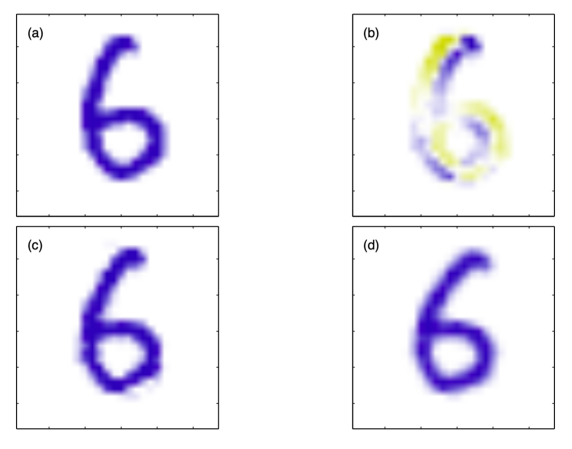

In [39]:
# 图5.16
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.16.png')
plt.axis('off')
ax.imshow(d)

正则化函数通过Jacobian矩阵$ J $对网络的权值产生依赖。通过对5.3节中讨论的方法进行推广，计算正则化项关于网络权值的导数的反向传播公式可以很容易地得到。如果变换由$ L $个参数控制（如，对于二维图像的平移变换与面内旋转变换项结合），那么流形$ M $的维度为$ L $，对应的正则化项由形如式（5.128）的项求和得到，每个变换都对应求和式中的一项。如果同时考虑若干个变换，且让网络映射对于每个变换分别具有不变性，那么对于变换的组合来说就会具有（局部）不变性）Simard et al., 1992）。
一个被称为切线距离（tangent distance）相关技术，可以用来构造基于距离的方法（如最近邻分类器）的不变性（Simard et al., 1993）。



### 5.5.5 用变换后的数据训练

我们已经知道，让模型对于一组变换具有不变性的一种方法是使用原始输入模式的变换后的模式来扩展训练集。这里，我们说明，这种方法与切线传播的方法密切相关（Bishop, 1995b; Leen, 1995）。
与5.5.4节一样，我们要考虑由单一参数$ \xi $控制的变换，且这个变换由函数$ s(x,\xi) $描述，其中$ s(x, 0) = x $。我们也会考虑平方和误差函数。对于未经过变换的输入，误差函数可以写成（在无限数据集的极限情况下）
$ E = \frac{1}{2}\int\int{y(x) - t}^2p(t|x)p(x)dxdt \tag{5.129} $
正如1.5.5节讨论的那样。这里，为了保持记号的简洁，我们考虑有一个输出单元的网络。如果我们现在考虑每个数据点的无穷多个由参数为$ \xi $的变换施加了扰动的副本，其中$ \xi $服从概率分布$ p(\xi) $，那么在这个扩展的误差函数上定义的误差函数可以写成
$ \tilde{E}=\frac{1}{2}\int\int\int{y(s(x,\xi)) - t}^2p(t|x)p(x)p(\xi)dxdtd\xi \tag{5.130} $
现在，我们假设分布$ p(xi) $的均值为0，且方差很小，即我们只考虑对原始输入向量的小的变换。对变换函数关于$ \xi $做泰勒展开得到
$ \begin{eqnarray} x(x,\xi) &=& s(x,0) + \xi\left.\frac{\partial}{\partial \xi}s(x,\xi)\vphantom{\Big|}\right| _{\xi = 0} + \frac{\xi^2}{2}\left.\frac{\partial^2}{\partial \xi^2}s(x,\xi)\vphantom{\Big|}\right| _{\xi = 0} + O(\xi^3) \ &=& x + \xi\tau + \frac{1}{2}\xi^2\tau' + O(\xi^3) \end{eqnarray} $
其中$ \tau' $表示$ s(x,\xi) $关于$ \xi $的二阶导数在$ \xi = 0 $处的值。这使得我们可以展开模型函数得到
$ y(s(x,\xi)) = y(x) + \xi\tau^T\nabla y(x) + \frac{\xi^2}{2}\left[(\tau')^T\nabla y(x) + \tau^T\nabla\nabla y(x)\tau\right] + O(\xi^3) $
代入平均误差函数（5.130）得到
$$
\begin{aligned}
\tilde{E}=& \frac{1}{2} \iint\{y(\boldsymbol{x})-t\}^{2} p(t \mid \boldsymbol{x}) p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x} \mathrm{d} t \\
+& \mathbb{E}[\xi] \iint\{y(\boldsymbol{x})-t\} \boldsymbol{\tau}^{T} \nabla y(\boldsymbol{x}) p(t \mid \boldsymbol{x}) p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x} \mathrm{d} t \\
+& \mathbb{E}\left[\xi^{2}\right] \frac{1}{2} \iint\left[\{y(\boldsymbol{x})-t\}\left\{\left(\boldsymbol{\tau}^{\prime}\right)^{T} \nabla y(\boldsymbol{x})+\boldsymbol{\tau}^{T} \nabla \nabla y(\boldsymbol{x}) \tau\right\}\right.\\
&\left.+\left(\boldsymbol{\tau}^{T} \nabla y(\boldsymbol{x})\right)^{2}\right] p(t \mid \boldsymbol{x}) p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x} \mathrm{d} t+O\left(\xi^{3}\right)
\end{aligned}
$$
由于变换的分布的均值为0，因此我们有$ \mathbb{E}[\xi] = 0 $。且，我们把$ \mathbb{E}[\xi^2] $记作$ \lambda $。省略$ O(\xi^3) $项，这样平均误差函数就变成了
$ \tilde{E} = E + \lambda\omega \tag{5.131} $
其中$ E $是原始的平方和误差，正则化项$ \omega $的形式为
$$
\begin{aligned}
\Omega=& \frac{1}{2} \int\left[\{y(\boldsymbol{x})-\mathbb{E}[t \mid \boldsymbol{x}]\}\left\{\left(\boldsymbol{\tau}^{\prime}\right)^{T} \nabla y(\boldsymbol{x})+\boldsymbol{\tau}^{T} \nabla \nabla y(\boldsymbol{x}) \tau\right\}\right.\\
&\left.+\left(\boldsymbol{\tau}^{T} \nabla y(\boldsymbol{x})\right)^{2}\right] p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x}
\end{aligned} \tag{5.132}
$$
其中我们已经对$ t $进行了积分。
我们可以进一步简化这个正则化项，如下所述。在1.5.5节，我们已经看到，使平方和误差函数达到最小值的函数为目标值$ t $的条件均值$ \mathbb{E}[t|x] $。根据式（5.131），我们看到正则化的误差函数等于非正则化的误差函数加上一个$ O(\xi^2) $的项，因此最小化总误差函数的网络函数的形式为
$ y(x) = \mathbb{E}[t|x] + O(\xi^2) \tag{5.133} $
从而，正则化项中的第一项消失，剩下的项为
$ \omega = \frac{1}{2}\int\left(\tau^T\nabla y(x)\right)^2p(x)dx \tag{5.134} $
这等价于切线传播的正则化项（5.128）。
如果我们考虑一个特殊情况，即输入变量的变换只是简单地添加随机噪声$ x \to x + xi $，那么正则化项的形式为
$ \omega = \frac{1}{2}\int\Vert \nabla y(x) \Vert^2p(x)dx \tag{5.135} $
这被称为Tikhonov正则化（Tikohonov and Arsenin, 1977; Bishop, 1995b）。这个正则化项关于网络权值的导数可以使用扩展的反向传播算法求出（Bishop, 1993）。我们看到，对于小的噪声，Tikhonov正则化与对输入添加随机噪声有关系。可以证明，在恰当的情况下，这种做法会提升模型的泛化能力。



### 5.5.6 卷集神经网络

另一种构造在输入变量的变换下具有不变性的模型的方法是将不变性的性质融入到神经网络结构的构建中。这是卷积神经网络（convolutional neural network）（LeCun et al., 1989; LeCun et al., 1998）的基础，它被广泛的应用于图像处理领域。
考虑手写数字识别这个具体的任务。每个输入图像由一组像素的灰度值组成，输出为10个数字类别的后验概率分布。我们知道，数字的种类对于平移、缩放以及（微小的）旋转具有不变性。此外，网络还必须对一些更微妙的变换具有不变性，如图5.14所示的弹性形变。一种简单的方法是把图像作为一个完全连接的神经网络的输入，如图5.1所示的网络。假设数据集充分大，那么这样的网络原则上可以得到这个问题的一个较好的解，从而可以从样本中学习到恰当的不变性。
然而，这种方法忽略了图像的一个关键性质，即距离较近的像素的相关性要远大于距离较远的像素的相关性。计算机视觉领域中，许多现代的方法通过抽取只依赖于图像里小的子区域的局部特征的方式来利用这个性质。之后，来自这些特征的信息就可以融合到后续处理阶段中，来检测更高级的特征，最后产生图像整体的信息。并且，对于图像的一个区域有用的局部特征可能对于图像的其他区域也有用，例如感兴趣的物体发生平移的情形。
通过(1)局部接收场，(2)权值共享，(3)二次采样这三种方式，可以把这些想法整合到了卷积神经网络中。卷积网络的结构如图5.17所示。

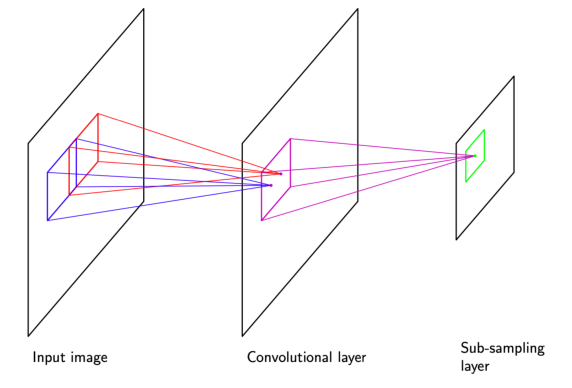

In [40]:
# 图5.17
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.17.png')
plt.axis('off')
ax.imshow(d)

 
在卷积层，各个单元被组织在一系列被称为特征地图（feature map）的平面中。每个特征地图中单元只从图像的一个小的子区域接收输入，且特征地图中的所有单元被限制为共享相同的权值。如，一个特征地图可能由100个单元组成，这些单元被放在了$ 10 \times 10 $的网格中，每个单元接受图像中一个$ 5 \times 5 $的像素块的输入。因此，整个特征地图就有25个可调节的权值参数，加上一个可调节的偏置参数。来自一个像素块的输入值通过权值和偏置进行线性组合，其结果通过式（5.1）给出的$ S $形非线性函数进行变换。如果我们把每个单元想象成特征检测器，那么特征地图中的所有单元都检测了输入图像中位置不同的相同的模式。由于权值共享，这些单元的激活计算等价于图像像素的灰度值与权向量组成的“核”进行卷积。如果输入图像发生平移，那么特征地图的激活也会发生等量的平移，否则就不发生改变。这提供了神经网络输出对于输入图像的平移和变形的（近似）不变性的基础。由于我们通常需要检测多个特征来构造一个有效的模型，因此通常在卷积层会有多个有自己的权值和偏置参数的特征地图。
卷积单元的输出构成了网络的二次采样层的输入。对于卷积层的每个特征地图，有一个二次采样层的单元组成的平面，且二次采样层的每个单元从对应的卷积层的特征地图中的一个小的接收场接收输入。这些单元执行二次采样。例如，每个二次采样单元可能从对应的特征地图中的一个$ 2 \times 2 $单元的区域中接收输入，然后计算这些输入的平均值，乘以一个可调节的权值和可调节的偏置参数，然后使用$ S $形非线性激活函数进行变换。选择的接收场是连续的、非重叠的，从而二次采样层的行数和列数都是卷积层的一半。使用这种方式，二次采样层的单元的结果对于对应的输入空间区域中的图片的微小平移相对不敏感。
在实际构造中，可能有若干卷积层和二次采样层对。在每个阶段，与前一层相比，都会有一个更高层次的关于输入变换的不变性。在一个给定的卷积层中，对于每个由前一个二次采样层的单元构成的平面，可能存在若干个特征地图，从而空间分辨率的逐层减小就可以通过增加特征的数量进行补偿。网络的最后一层通常是完全连接的，是一个完全可调节的层。在多分类问题中，输出层使用的是softmax非线性函数。
整个网络可以使用误差函数最小化的方法计算。误差函数梯度的计算可以使用反向传播算法。这需要对一般的反向传播算法进行微小的修改，来确保共享权值的限制能够满足。由于使用局部接收场，网络中权值的数量要小于完全连接的网络的权值数量。此外，由于权值上的大量限制，需要从训练数据中学习到的独立参数的数量仍然相当小。



### 5.5.7 软权值共享

降低具有大量权值参数的网络复杂度的一种方法是将权值分组,然后令分组内的权值相等。这是5.5.6节中讨论的将网络对于图像的平移不变性整合到网络的构建过程中的权值共享的方法。然而，它只适用于限制的形式可以事先确定的问题中。这里，我们考虑软权值共享（soft weight sharing）（Nowlan and Hinton, 1992）。这种方法中，权值相等的硬限制被替换为一种形式的正则化，其中权值的分组倾向于取近似的值。此外，权值的分组、每组权值的均值，以及分组内的取值范围全都作为学习过程的一部分被确定。
回忆一下，式（5.112）给出的简单的权值衰减正则化项可以被看成权值上的高斯分布的负对数。我们可以将权值分为若干组，而不是将所有权值分为一个组。分组的方法是使用高斯混合概率分布。混合分布中，每个高斯分量的均值、方差，以及混合系数，都会作为可调节的参数在学习过程中被确定。于是，我们有形式为
$ p(w) = \prod\limits_i p(w_i) \tag{5.136} $
的概率密度。其中
$ p(w_i) = \sum\limits_{j=1}^M \pi_j \mathcal{N}(w_i|\mu_j,\sigma_j^2) \tag{5.137} $
$ \pi_j $为混合系数。取负对数，即可得到形式为
$ \omega(w) = -\sum\limits_i \ln \left(\sum\limits_{j=1}^M\pi_j \mathcal{N}(w_i|\mu_j,\sigma_j^2)\right) \tag{5.138} $
正则化函数。从而，总的误差函数为
$ \tilde{E}(w) = E(w) + \lambda\omega(w) \tag{5.139} $
其中，$ \lambda $是正则化系数。这个误差函数同时关于权值$ w_i $和混合模型参数$ {pi_j, \mu_j, \sigma_j} $进行最小化。如果权值是常数,那么混合模型的参数可以由第9章讨论的EM算法确定。然而，权值分布本身在学习过程中是不断变化的，因此为了避免数值的不稳定性，我们同时关于权值和混合模型参数进行最优化。可以使用标准的最优化算法（例如共轭梯度法或拟牛顿法）来完成这件事。
为了最小化总的误差函数，计算出它关于各个可调节参数的导数是很有必要的。为了完成这一点，比较方便的做法是把$ {\pi_j} $当成先验概率，然后引入对应的后验概率。根据式（2.192），后验概率由贝叶斯定理给出的形式为
$ \gamma_i(w) = \frac{\pi_j\mathcal{N}(w|\mu_j,\sigma_j^2)}{\sum_k\pi_k\mathcal{N}(w|\mu_k,\sigma_k^2)} \tag{5.140} $
这样，总误差函数关于权值的导数为
$ \frac{\partial\tilde{E}}{\partial w_i} = \frac{\partial E}{\partial w_i} + \lambda\sum\limits_j\gamma_j(w_i)\frac{(w_i - \mu_j)}{\delta_j^2} \tag{5.141} $
于是，正则化项的效果是使用大小为正比于对于给定权值的高斯分布的后验概率的力把每个权值拉向第$ j $个高斯分布的中心,拉力。这恰好就是我们要寻找的效果。
误差函数关于高斯分布的中心的导数也很容易的得到结果：
$ \frac{\partial\tilde{E}}{\partial\mu_j} = \lambda\sum\limits_i\gamma_j(w_i)\frac{(\mu_i-w_j)}{\sigma_j^2} \tag{5.142} $
它具有简单的直观含义，因为它使用大小为第j个高斯分量产生的权值参数的后验概率的力把$ \mu_j $拉向了权值的平均值。类似地，关于方差的导数为
$ \frac{\partial\tilde{E}}{\partial\sigma_j} = \lambda\sum\limits_i\gamma_j(w_i)\left(\frac{1}{\sigma_j} - \frac{(w_j - \mu_j)^2}{\sigma_j^3}\right) \tag{5.143} $
它将$ \sigma_j $拉向权值在对应的中心$ mu_j $附近的偏差的平方的加权平均，加权平均的权系数与之前一样，等于由第$ j $个高斯分量产生的权值参数的后验概率。注意，在实际执行过程中，我们会引入一个由
$ \sigma_j^2 = exp(\xi_j) \tag{5.144} $
定义的新变量$ \xi_j $。且，最小化的过程是关于$ \xi_j $进行的。这确保了参数$ \sigma_j $是正数。此外，它还能够倾向于避免找到病态解，即一个或多个$ \sigma_j $趋于零，对应高斯分量退化为权参数的值。9.2.1节会在高斯混合模型的问题中详细讨论这样的解。
对于关于混合系数$ \pi_j $的导数，需要考虑限制条件：
$ \sum\limits_j\pi_j = 1, 0 \leq \pi_j \leq 1 \tag{5.145} $
这个限制的产生，是因为我们把$ \pi_j $看成了先验概率。可以这样做：将混合系数通过一组辅助变量$ {\eta_j} $用softmax函数表示，即
$ \pi_j = \frac{exp(\eta_j)}{\sum_{k=1}^Mexp(\eta_k)} \tag{5.146} $
这样，正则化的误差函数关于$ {\eta_j} $的导数的形式为
$ \frac{\partial\tilde{E}}{\partial\eta_j} = \sum\limits_i{\pi_j - \gamma_j(w_i)} \tag{5.147} $
我们看到，$ \pi_j $被拉向第$ j $个高斯分量的平均后验概率。



## 5.6 混合密度网络

有监督学习的目标是对条件概率分布$ p(t|x) $建模。对于许多简单的回归问题来说，这个分布都被设为高斯分布。然而，实际的机器学习问题中，经常会遇到与高斯分布差别相当大的概 率分布。如，在逆问题（inverse problem）中，概率分布可以是多峰的，这种情况下，高斯分布的假设就会产生相当差的预测结果。
作为逆问题的一个简单的例子，考虑机械臂的运动学问题，如图5.18所示。

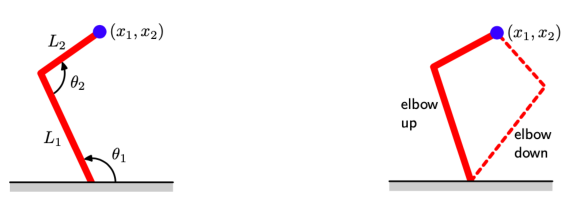

In [41]:
# 图5.18
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.18.png')
plt.axis('off')
ax.imshow(d)

正向问题（forward problem）是在给定连接角的情况下求解机械臂末端的位置，这个问题有唯一解。然而，在实际应用中，我们想把机械臂末端移动到一个具体的位置。为了完成移动，我们必须设定合适的连接角。于是，我们需要求解逆问题，它有两个解，如图5.18所示。
正向问题通常对应于物理系统的因果关系，通常有唯一解。例如，人体的某个具体的症状是由于特定的疾病造成的。然而在模式识别中，我们通常不得不求解逆问题，例如在给定症状的情况下，推断疾病的种类。如果正向问题涉及到多对一的映射，那么逆问题就会有多个解。例如，多种不同的疾病可能会导致相同的症状。
在机械臂的例子中，运动由几何方程定义，多峰的性质是显然的。然而，在许多机器学习问题中，尤其是涉及到高维空间的问题中，多峰性质的存在并不显然。但是，为了教学的目的，我们会考虑一个相当简单的问题，这个问题中我们可以很容易地看出多峰性质。这个问题的数据的生成方式为:对服从区间$ (0, 1) $的均匀分布的变量$ x $进行取样，得到一组值$ {x_n} $，对应的目标值$ t_n $通过下面的方式得到：计算函数$ x_n + 0.3\sin(2\pi x_n) $，然后添加一个服从$ (−0.1, 0.1) $上的均匀分布的噪声。这样，就可以通过使用相同的数据点，但是交换$ x, t $的角色来得到逆问题。图5.19给出了正向问题和逆问题的数据集，以及一个两层神经网络给出的结果。

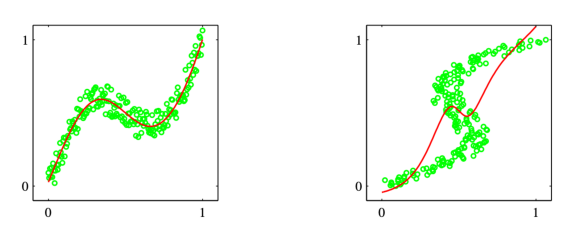

In [42]:
# 图5.19
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.19.png')
plt.axis('off')
ax.imshow(d)

这个两层的神经网络有6个隐含单元，一个线性输出单元，误差函数为平方和误差函数。在高斯分布的假设下，最小平方方法对应于最大似然方法。我们看到，对于不服从高斯分布的逆问题，这种解法产生的模型非常差。
于是，我们通过为$ p(t|x) $使用一个混合模型，模型的混合系数和每个分量的概率分布都是输入向量$ x $的一个比较灵活的函数来找到一个对条件概率密度建模的一般的框架。这就构成了混合密度网络（mixture density network）。对于任意给定的$ x $值，混合模型提供了一个通用的形式,用来对任意条件概率密度函数$ p(t|x) $进行建模。假设我们考虑一个足够灵活的网络，那么我们就有了一个近似任意条件概率分布的框架。
这里，我们显式地令模型的分量为高斯分布，即
$ p(t|x) = \sum\limits_{k=1}^K\pi_k(x)\mathcal{N}(t|\mu_k(x),\sigma_k^2(x)I) \tag{5.148} $
这是异方差模型（heteroscedastic model）的一个例子，因为数据中的噪声方差是输入向量$ x $的一个函数。我们也可以使用高斯分布以外的其他分布，如，如果目标变量是二值的而不是连续的，我们就可以使用伯努利分布。我们已经把情况具体到了各向同性的协方差的情形，虽然可以通过使用Cholesky分解（Williams, 1996）表示协方差的方式，将混合密度网络扩展到可以处理更一般的协方差的情形。即使每个分量的方差是各向同性的，但是我们仍然不能假设条件概率分布$ p(t|x) $能够关于t的分量进行分解（这与标准的平方和回归模型不同），这是由于概率分布是一个混合分布。
我们现在为混合模型取各种不同的参数，这些参数包括混合系数$ \pi k(x) $、均值$ \mu_k(x) $以及方差$ \sigma_k^2(x) $，这些参数控制了以$ x $作为输入的神经网络的输出。这个混合密度网络的结构如图5.20所示。混合密度网络与14.5.3节讨论的混合专家的关系十分紧密。主要的区别是，混合密度网络使用相同的函数来预测所有分量概率分布的参数以及混合参数，因此非线性隐含单元被依赖于输入的函数所共享。
图5.20所示的神经网络可以是一个具有$ S $形（双曲正切）隐藏单元的两层的网络。



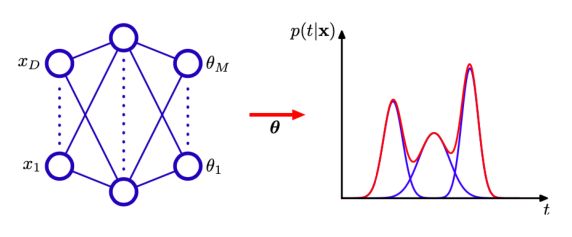

In [43]:
# 图5.20
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.20.png')
plt.axis('off')
ax.imshow(d)


如果混合模型（5.148）中有$ K $个分量，且$ t $有$ L $个分量，那么网络就会有$ K $个输出单元激活（记作$ a_k^\pi $ ）确定混合系数$ \pi_k(x) $，有$ K $个输出（记作$ a_k^\sigma $）确定核宽度$ \sigma_k(x) $，有$ K \times L $个输出（记作$ a_{kj}^\mu $)确定核中心$ \mu_k(x) $的分量$ \mu_{kj}(x) $。网络输出的总数为$ (L + 2)K $，这与通常的网络的$ L $个输出不同。通常的网络只是简单地预测目标变量的条件均值。
混合系数必须满足
$ \sum\limits_{k=1}^K\pi_k(x) = 1, 0 \leq \pi_k(x) \leq 1 \tag{5.149} $
的限制。可以通过使用一组softmax输出来实现。
$ \pi_k(x) = \frac{exp(a_k^\pi)}{\sum_{l=1}^K exp(a_l^\pi)} \tag{5.150} $
同样的，方差必须满足$ \sigma_k^2(x) \geq 0 $，因此可以使用对应的网络激活的指数形式表示：
$ \sigma_k(x) = exp(a_k^\sigma) \tag{5.151} $
最后，由于均值$ \mu_k(x) $有实数分量，因此它们可以直接用网络的输出激活表示
$ \mu_{kj}(x) = a_{kj}^\mu \tag{5.152} $
混合密度网络的可调节参数由权向量$ w $和偏置组成。这些参数可以通过最大似然法确定，或等价地，使用最小化误差函数（负对数似然函数）的方法确定。对于独立的数据，误差函数的形式为
$$
E(\boldsymbol{w})=-\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k}\left(\boldsymbol{x}_{n}, \boldsymbol{w}\right) \mathcal{N}\left(\boldsymbol{t}_{n} \mid \boldsymbol{\mu}_{k}\left(\boldsymbol{x}_{n}, \boldsymbol{w}\right), \sigma_{k}^{2}\left(\boldsymbol{x}_{n}, \boldsymbol{w}\right) \boldsymbol{I}\right)\right\}
\tag{5.153} $$
其中，我们显式地写出了误差函数对于$ w $的依赖。
为了最小化误差函数，我们需要计算误差函数$ E(w) $关于$ w $的分量的导数。如果我们得到了误差函数关于输出单元激活的导数的表达式，那么我们就可以通过标准的反向传播方法来计算误差函数关于$ w $的分量的导数。误差函数关于输出单元激活的导数代表了每个模式和每个输出单元的误差信号$ \sigma $并且可以反向传播到隐含单元，从而误差函数的导数可以按照通常的方式进行计算。由于误差函数（5.153）由一组项的求和式构成，每一项都对应一个训练数据点，因此我们可以考虑对于特定的模式$ n $的导数，然后通过求和的方式找到$ E $的导数。
由于我们处理的是混合概率分布，因此比较方便的做法是把混合系数$ \pi_k(x) $看成与$ x $相关的先验概率分布，从而就引入了对应的后验概率，形式为
$ \gamma_{nk} = \gamma_k(t_n|x_n) = \frac{\pi_k\mathcal{N}{nk}}{\sum{l=1}^K\pi_l\mathcal{N}_{nl}} \tag{5.154} $
其中$ \mathcal{N}_{nk} $表示$ \mathcal{N}(t_n|\mu_k(x_n),\sigma_k^2(x_n)) $。
关于控制混合系数的网络输出激活的导数为
$ \frac{\partial E_n}{\partial a_k^\pi} = \pi_k - \gamma_{nk} \tag{5.155} $
类似地，关于控制分量均值的网络输出激活的导数为
$$
\frac{\partial E_{n}}{\partial a_{k l}^{\mu}}=\gamma_{k}\left\{\frac{\mu_{k l}-t_{n l}}{\sigma_{k}^{2}}\right\}
\tag{5.156}$$
最后，关于控制分量方差的网络激活函数为
$$
\frac{\partial E_{n}}{\partial a_{k}^{\sigma}}=\gamma_{n k}\left\{L-\frac{\left\|\boldsymbol{t}_{n}-\boldsymbol{\mu}_{k}\right\|^{2}}{\sigma_{k}^{2}}\right\}
\tag{5.157} $$
我们回到图5.19所示的逆问题的简单例子，来说明混合密度网络的应用。图5.21给出了混合系数$ \pi_k(x) $、均值$ \mu_k(x) $和对应于$ p(t|x) $的条件概率等高线。

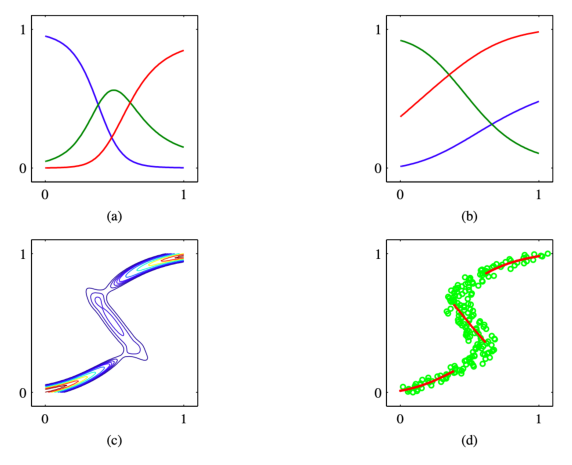

In [44]:
# 图5.21
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图5.21.png')
plt.axis('off')
ax.imshow(d)

神经网络的输出，即混合模型的参数，是输入变量的连续单值函数。然而，从图5.21(c)中我们可以看到，通过调整混合分 量$ \pi_k(x) $的大小，模型能够产生一个对于某些$ x $是单峰的，而对于其它$ x $值是多峰的概率分布。
一旦混合密度网络训练结束，它就可以预测对于任意给定的输入向量的目标数据的条件密度函数。只要我们关注的是预测输出向量的值的问题，那么这个条件概率密度就能完整地描述用于生成数据的概率分布。根据这个概率密度函数，我们可以计算不同应用中我们感兴趣的更加具体的量。一个最简单的量就是目标数据的条件均值：
$ \mathbb{E}[t|x] = \int tp(t|x)dt = \sum\limits_{k=1}^K\pi_k(x)\mu_k(x) \tag{5.158} $
其中我们使用了式（5.148）。由于使用最小平方方法训练的标准的神经网络近似了条件均值，因此我们看到作为一个特例，混合密度网络可以复制传统的最小平方的结果。当然，正如我们已经注意到的那样，对于一个多峰分布，条件均值是一个受限的值。
同样的，我们可以利用条件均值的结果，计算密度函数的方差：
$$
\begin{array}{r}
s^{2}(\boldsymbol{x})=\mathbb{E}\left[\|\boldsymbol{t}-\mathbb{E}[\boldsymbol{t} \mid \boldsymbol{x}]\|^{2} \mid \boldsymbol{x}\right] \\
=\sum_{k=1}^{K} \pi_{k}(\boldsymbol{x})\left\{\sigma_{k}^{2}(\boldsymbol{x})+\left\|\boldsymbol{\mu}_{k}(\boldsymbol{x})-\sum_{l=1}^{K} \pi_{l}(\boldsymbol{x}) \boldsymbol{\mu}_{l}(\boldsymbol{x})\right\|^{2}\right\}
\end{array} \tag{5.159,5.160}
$$
其中我们使用了式（5.148）和（5.158）。与对应的最小平方结果相比，因为方差是$ x $的一个函数，所以这个结果更一般。
我们已经看到，对于多峰分布，用条件均值描述数据的效果很差。例如，在图5.18给出的控制机械臂的例子中，我们需要从两个可能的连接角中选出一个，来得到所需的末端位置。在这种情况下，条件众数可能更有价值。由于混合密度网络的条件众数没有一个简单的解析解，因此需要数值迭代。一个简单的替代方法是取每个$ x $对应的最可能分量（即具有最大混合系数的分量）的均值。对于之前的那个简单的例子，图5.21(d)给出了这个结果。



In [13]:
#data
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [14]:
#model
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_components):
        self.n_components = n_components
        super().__init__()
        with self.set_parameter():
            self.w1 = nn.random.truncnormal(-2, 2, 1, (n_input, n_hidden))
            self.b1 = nn.zeros(n_hidden)
            self.w2c = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2c = nn.zeros(n_components)
            self.w2m = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2m = nn.zeros(n_components)
            self.w2s = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2s = nn.zeros(n_components)

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        coef = nn.softmax(h @ self.w2c + self.b2c)
        mean = h @ self.w2m + self.b2m
        std = nn.exp(h @ self.w2s + self.b2s)
        return coef, mean, std
    
def gaussian_mixture_pdf(x, coef, mu, std):
    gauss = (
        nn.exp(-0.5 * nn.square((x - mu) / std))
        / std / np.sqrt(2 * np.pi)
    )
    return (coef * gauss).sum(axis=-1)

In [15]:
# training
model = MixtureDensityNetwork(1, 5, 3)
optimizer = nn.optimizer.Adam(model.parameter, 1e-4)

for i in range(30000):
    model.clear()
    coef, mean, std = model(x_train)
    log_likelihood = nn.log(gaussian_mixture_pdf(y_train, coef, mean, std)).sum()
    optimizer.maximize(log_likelihood)

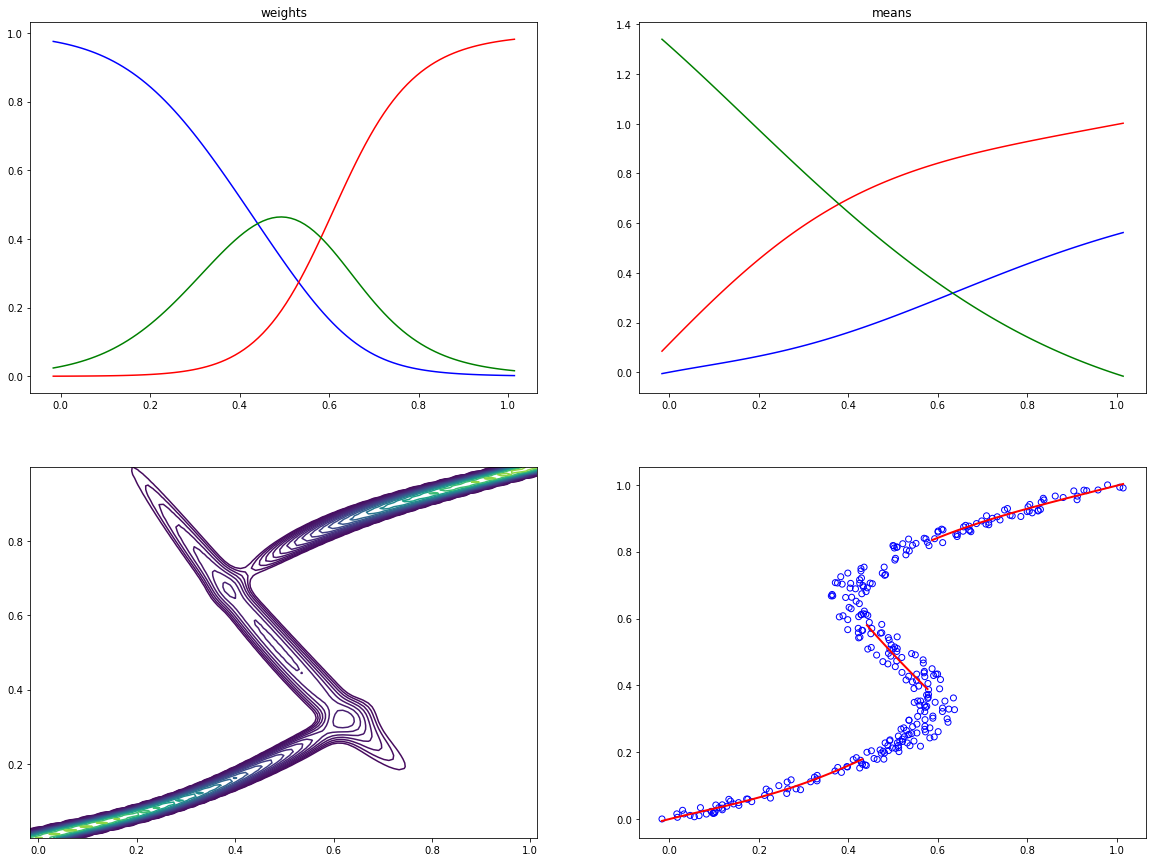

In [16]:
# plot
x = np.linspace(x_train.min(), x_train.max(), 100)[:, None]
y = np.linspace(y_train.min(), y_train.max(), 100)[:, None, None]
coef, mean, std = model(x)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[:, 0], coef.value[:, 0], color="blue")
plt.plot(x[:, 0], coef.value[:, 1], color="red")
plt.plot(x[:, 0], coef.value[:, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[:, 0], mean.value[:, 0], color="blue")
plt.plot(x[:, 0], mean.value[:, 1], color="red")
plt.plot(x[:, 0], mean.value[:, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
proba = gaussian_mixture_pdf(y, coef, mean, std).value
levels_log = np.linspace(0, np.log(proba.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
xx, yy = np.meshgrid(x.ravel(), y.ravel())
plt.contour(xx, yy, proba.reshape(100, 100), levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(coef.value, axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[indices, 0], mean.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 贝叶斯神经网络

目前为止，我们对于神经网络的讨论集中于使用最大似然方法来确定网络的参数（权值和偏置）。正则化的最大似然方法可以看成MAP（maximum posterior）方法，其中正则化项可以被看成先验参数分布的对数。然而，在贝叶斯方法中，为了进行预测，我们需要对参数的概率分布进行积分或求和。

在3.3节，我们研究了在高斯噪声假设下的简单线性回归模型的贝叶斯解。我们看到，后验概率分布（是一个高斯分布）可以精确计算，并且预测分布也具有解析解。在多层神经网络的情况下，网络函数对于参数值的高度非线性的性质意味着精确的贝叶斯方法不再可行。事实上，后验概率分布的对数是非凸的，对应于误差函数中的多个局部极小值。

第10章将要讨论在贝叶斯神经网络中使用变分推断方法。这种方法使用了对后验概率的分解的高斯近似（Hinton and van Camp， 1993），也使用了一个具有完全协方差矩阵的高斯分布(Barber and Bishop，1998a; Barber and Bishop， 1998b)。但是，最完整的贝叶斯方法是构成了本节讨论基础的基于拉普拉斯近似的方法(MacKay，1992c; MacKay， 1992b)。我们会使用一个以真实后验概率的众数为中心的高斯分布来近似后验概率分布。此外，我们会假设这个高斯分布的协方差很小，从而网络函数关于参数空间的区域中的参数近似是线性的。在参数空间中，后验概率距离概率为零的状态相当远。使用这两个近似，我们会得到与之前讨论的线性回归和线性分类的模型相类似的模型，从而我们就可以利用之前得到了结果了。这样，我们可以使用模型证据的框架来对参数进行点估计，并比较不同的模型（如，有着不同的隐藏单元数量的网络）。首先，我们讨论回归问题的情形，然后，针对分类问题进行必要的修改。

In [17]:
# data
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]

In [18]:
# model
class Gaussian(nn.Network):

    def __init__(self, shape):
        super().__init__()
        with self.set_parameter():
            self.m = nn.zeros(shape)
            self.s = nn.zeros(shape)

    def __call__(self):
        self.q = nn.Gaussian(self.m, nn.softplus(self.s) + 1e-8)
        return self.q.draw()


class BayesianNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__()
        with self.set_parameter():
            self.qw1 = Gaussian((n_input, n_hidden))
            self.qb1 = Gaussian(n_hidden)
            self.qw2 = Gaussian((n_hidden, n_hidden))
            self.qb2 = Gaussian(n_hidden)
            self.qw3 = Gaussian((n_hidden, n_output))
            self.qb3 = Gaussian(n_output)
        self.posterior = [self.qw1, self.qb1, self.qw2, self.qb2, self.qw3, self.qb3]
        self.prior = nn.Gaussian(0, 1)

    def __call__(self, x):
        h = nn.tanh(x @ self.qw1() + self.qb1())
        h = nn.tanh(h @ self.qw2() + self.qb2())
        return nn.Bernoulli(logit=h @ self.qw3() + self.qb3())
    
    def kl(self):
        kl = 0
        for pos in self.posterior:
            kl += nn.loss.kl_divergence(pos.q, self.prior).mean()
        return kl

In [19]:
# training
model = BayesianNetwork(2, 5, 1)
optimizer = nn.optimizer.Adam(model.parameter, 0.1)
for i in range(1, 2001, 1):
    model.clear()
    py = model(x_train)
    elbo = py.log_pdf(y_train).mean(0).sum() - model.kl() / len(x_train)
    optimizer.maximize(elbo)
    if i % 100 == 0:
        optimizer.learning_rate *= 0.9

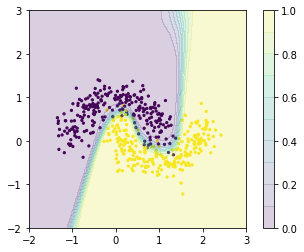

In [20]:
# plot
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y = np.mean([model(x_grid).mean.value.reshape(100, 100) for _ in range(10)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel(), s=5)
plt.contourf(x1, x2, y, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 5.7.1 后验参数分布

考虑从输入向量$ x $预测单一连续目标变量$ t $的问题（扩展到多个目标变量的情形很容易）。我们假设条件概率分布$ p(t|x) $是一个高斯分布，均值与$ x $有关，由神经网络模型的输出$ y(x, w) $确定，精度（方差的逆）$ \beta $为
$ p(t|x,w,\beta) = \mathcal{N}(t|y(x,w),\beta^{-1}) \tag{5.161} $
同样的，我们将权值$ w $的先验概率分布设为形式为
$ p(w|\alpha) = \mathcal{N}(w|O,\alpha^{-1}I) \tag{5.162} $
的高斯分布。对于$ N $次独立同分布的观测$ x_1,...,x_N $，对应的目标值集合$ D = {t_1,...,t_N} $，似然函数为
$ p(D|w,\beta) = \prod\limits_{n=1}^N\mathcal{N}(t_n|y(x_n,w),\beta^{-1}) \tag{5.163} $
因此最终的后验概率为
$ p(w|D,\alpha,\beta) \propto p(w|\alpha)p(D|w,\beta) \tag{5.164} $
由于$ y(x, w) $与$ w $的关系是非线性的，因此后验概率不是高斯分布。
使用拉普拉斯近似，我们可以找到对于后验概率分布的一个高斯近似。为了达到这个目的，我们必须首先需要得到使用迭代的数值最优化算法才能找到的后验概率分布的一个（局部）最大值。同样的，比较方便的做法是最大化后验概率分布的对数：
$ \ln p(w|D) = -\frac{\alpha}{2}w^Tw - \frac{\beta}{2}\sum\limits_{n=1}^N{y(x_n,w) - t_n}^2 + const \tag{5.165} $
这对应于一个正则化的平方和误差函数。假设$ \alpha, \beta $都是定值，那么我们可以通过标准的非线性最优化算法（如共轭梯度法），使用误差反向传播计算所需的导数，找到后验概率的最大值。我们将最大值的位置记作$ w_{MAP} $。
找到了$ w_{MAP} $的众数，我们就可以通过计算后验概率分布的负对数的二阶导数，建立一个局部的高斯近似。根据式（5.165），负对数后验概率的二阶导数为
$ A = -\nabla\nabla\ln p(w|D,\alpha,\beta) = \alpha I + \beta H \tag{5.166} $
这里，$ H $是一个Hessian矩阵，由平方和误差函数关于$ w $的分量组成。计算和近似Hessian矩阵的方法已经在4节讨论过。这样，根据式（4.134）可以得到后验概率对应的形式为
$ q(w|D) = \mathcal{N}(w|w_{MAP},A^{-1}) \tag{5.167} $
高斯近似。同样，预测分布可以通过将后验概率分布求积分的方式获得
$ p(t|x,D) = \int p(t|x,w)q(w|D)dw \tag{5.168} $
然而，即使是后验分布的高斯近似，因为网络函数$ y(x,w) $与$ w $的关系是非线性的，这个积分仍然无法得到解析解。为了将计算过程进行下去，现在我们假设，与$ y(x,w) $发生变化造成的$ w $的变化幅度相比，后验概率分布的方差较小。这使得我们可以在$ w_{MAP} $附近对网络函数进行泰勒展开。只保留展开式的线性项，可得：
$ y(x,w) \simeq y(x,w_{MAP}) + g^T(w - w_{MAP}) \tag{5.169} $
其中我们定义
$ g = \nabla_wy(x,w)\vert_{w=w_{MAP}} \tag{5.170} $
使用这个近似，我们得到了一个线性高斯模型，$ p(w) $为高斯分布。且$ p(t|w) $也是高斯分布，它的均值是$ w $的线性函数，分布的形式为
$ p(t|x,w,\beta) \simeq \mathcal{N}(t|y(x,w_{MAP}) + g^T(w-w_{MAP}), \beta^{-1}) \tag{5.171} $
于是我们可以使用式（2.115）给出的边缘分布$ p(t) $的一般结果，得到
$ p(t|x,D,\alpha,\beta) = \mathcal{N}(t|y(x,w_{MAP}),\sigma^2(x)) \tag{5.172} $
其中，与输入相关的方差为
$ \sigma^2(x) = \beta^{-1} + g^TA^{-1}g \tag{5.173} $
我们看到预测分布$ p(t|x,D) $是一个高斯分布，它的均值由网络函数$ y(x,w_{MAP}) $给出，参数设置为了MAP值。方差由两项组成：第一项来自目标变量的固有噪声，第二项是一个与$ x $相关的项，表示由于模型参数$ w $的不确定性造成的内插的不确定性。可以将这个结果与式（3.58）和（3.59）给出的线性回归模型的对应的预测分布进行对比。



### 5.7.2 超参数最优化

目前为止，我们假定了超参数$ \alpha, \beta $是固定的、已知的。我们可以使用3.5节讨论的模型证据框架，结合使用拉普拉斯近似得到的后验概率的高斯近似，得到确定这些超参数的值的步骤。
超参数的边缘似然函数，或模型证据，可以通过对网络权值进行积分的方法得到：
$ p(D|\alpha,\beta) = \int p(D|w,\beta)p(w|\alpha)dw \tag{5.174} $
通过使用拉普拉斯近似的结果（4.135），这个积分很容易计算。取对数，得到
$ \ln p(D|\alpha,\beta) \simeq - E(w_{MAP}) - \frac{1}{2}\ln\vert A \vert + \frac{W}{2}\ln\alpha + \frac{N}{2}\ln\beta - \frac{N}{2}\ln (2\pi) \tag{5.175} $
其中$ W $是$ w $中参数的总数。正则化误差函数的定义为
$ E(w_{MAP}) = \frac{\beta}{2}\sum\limits_{n=1}^N{y(x_n,w_{MAP}) - t_n}^2 + \frac{\alpha}{2}w_{MAP}^Tw_{MAP} \tag{5.176} $
我们看到这与线性回归模型的对应的结果（3.86）的函数形式相同。
在模型证据框架中，我们通过最大化$ \ln p(D | \alpha, \beta) $对$ \alpha, \beta $进行点估计。首先考虑关于$ \alpha $进行最大化，这可以通过与3.5.2节讨论的线性回归的情形相类似的方法计算。首先，我们定义特征值方程
$ \beta H\mu_i = \lambda_i\mu_i \tag{5.177} $
其中$ H $是在$ w = w_{MAP} $处计算的Hessian矩阵，由平方和误差函数的二阶导数组成。通过类比式（3.92）得到
$ \alpha = \frac{\gamma}{w_{MAP}^Tw_{MAP}} \tag{5.178} $
其中$ \gamma $表示参数的有效数量，定义为
$ \gamma = \sum\limits_{i=1}^W\frac{\lambda_i}{\alpha + \lambda_i} \tag{5.179} $
注意，这个结果与线性回归的情形完全相同。然而，对于非线性神经网络，它忽略了下面的事实：$ \alpha $的改变会引起Hessian矩阵H的改变，进而改变特征值。于是，我们隐式地忽略了涉及到$ \lambda_i $关于$ \alpha $的导数的项。
同样的，根据式（3.95），我们看到，关于$ \beta $最大化模型证据，可以得到形式为
$ \frac{1}{\beta} = \frac{1}{N - \gamma}\sum\limits_{n=1}^N{y(x_n,w_{MAP}) - t_n}^2 \tag{5.180} $
的重估计公式。
与线性模型一样，我们需要交替地进行超参数$ \alpha, \beta $的重新估计以及后验概率分布的更新。然而，对于神经网络来说，由于后验概率分布的多峰性质，情况更复杂。结果，使用最大化对数后验概率的方法找到的解$ w_{MAP} $将依赖于$ w $的初始化。只要我们考虑的是预测问题，那么仅仅由于隐藏层的结点交换和符号改变所造成的不同结果将给出相同的预测，并且预测的结果与等价解中的哪一个解被找到没有关系。然而，也可能存在不等价的解，这些通常会产生不同的最优超参数。
为了比较不同的模型，如具有不同隐含单元数量的神经网络，我们需要计算模型证据$ p(D) $。将使用迭代最优化过程得到的超参数值$ \alpha, \beta $代入式（5.175），我们可以得到模型证据的近似。一个更加仔细的计算方法是关于$ \alpha, \beta $求积分，并同时使用一个高斯近似(MacKay, 1992; Bishop, 1995a)。在这两种方法中，都需要计算Hessian矩阵的行列式$ \vert A \vert $。因为与矩阵的迹不同，行列式对于小的特征值比较敏感，而这些特征值通 常很难精确计算，这在实际应用中会有很大的问题。
拉普拉斯近似基于的是权值的后验概率分布的众数附近的局部二次展开。在5.1.1节，我们已经看到，在两层神经网络中，任意给定的众数都是$ M!2^M $个等价的众数中的一个，这些等价的众数由网络的互换对称性和符号对称性造成，其中$ M $是隐藏结点的数量。当比较具有不同隐藏结点数量的网络时，考虑到这一点需要将模型证据乘以因子$ M!2^M $。



### 5.7.3 用于分类的贝叶斯神经网络

目前，我们已经使用了拉普拉斯近似，推导出了神经网络回归模型的贝叶斯方法。现在，我们要讨论的是，当应用于分类问题时，这个框架应该如何修改。这里，对应于一个二分类问题，我们的网络需要有一个logistic sigmoid输出。将网络扩展到多类softmax输出是很直接的。 我们构建神经网络的过程与4.5节讨论线性分类模型的结果十分类似，因此我们建议读者在学习本节之前，应该对那一节的内容比较熟悉。
模型的对数似然函数为
$ \ln p(D|w) = \sum\limits_{n=1}^N{t_n\ln y_n + (1 - t_n)\ln (1-y_n)} \tag{5.181} $
其中$ t_n \in {0, 1} $是目标值，且$ y_n \equiv y(x_n, w) $。注意，因为我们假定数据点被正确标记了，所以这里没有超参数$ \beta $。同样的，先验概率分布是式（5.162）给出的各向同性高斯分布。
将拉普拉斯框架用在这个模型中的第一个阶段是初始化超参数$ \alpha $，然后通过最大化对数后验概率分布的方法确定参数向量$ w $。这等价于最小化正则化误差函数
$ E(w) = -\ln p(D|w) + \frac{\alpha}{2}w^Tw \tag{5.182} $
最小化的过程可以通过使用误差反向传播方法结合标准的最优化算法得到，正如5.3节所说的那样。
找到权向量的解$ w_{MAP} $之后，下一步是计算由负对数似然函数的二阶导数组成的Hessian矩阵$ H $。这可以通过使用5.4.5节介绍的精确方法，或使用式（5.85）给出的外积近似方法求得。负对数后验概率的二阶导数可以写成式（5.166）的形式，这样，后验概率的高斯近似就由式（5.167）给出。
为了最优化超参数$ \alpha $，我们再次最大化边缘似然函数。很容易证明，边缘似然函数的形式为
$ \ln p(D|\alpha) \simeq - E(w_{MAP}) - \frac{1}{2}\ln\vert A \vert + \frac{W}{2}\ln\alpha \tag{5.183} $
其中，正则化的误差函数为
$ E(w_{MAP}) = -\sum\limits_{n=1}^N{t_n\ln y_n + (1-t_n)\ln(1-y_n)} + \frac{\alpha}{2}w_{MAP}^Tw_{MAP} \tag{5.184} $
其中$ y_n \equiv y(x_n, w_{MAP}) $。关于$ \alpha $再次最大化这个模型证据函数，可以得到式（5.178）给出的再估计方程。
使用模型证据的方法确定$ \alpha $的步骤如图5.22所示，所用的数据集在附录A中讨论。
最后，我们需要找到式（5.168）定义的预测分布。与之前一样，由于网络函数的非线性的性质，积分是无法直接计算的。最简单的近似方法是假设后验概率非常窄，因此可以进行形式为
$ p(t|x,D) \simeq p(t|x,w_{MAP}) \tag{5.185} $
的近似。然而，我们可以放宽这个假设，通过考虑后验概率分布的方差。在这种情况下，与回归问题的情形相同，因为输出单元激活函数是将输出限制在了区间$ (0, 1) $上的logistic sigmoid函数，所以对网络输出进行线性近似是不合适的。相反，我们对输出激活函数进行形式为
$ a(x,w) \simeq a_{MAP}(x) + b^T(w-w_{MAP} \tag{5.186} $
线性近似，其中$ a_{MAP}(x) = a(x, w_{MAP}) $以及向量$ b \equiv \nabla a(x, w_{MAP}) $都可以通过反向传播方法求出。
由于我们现在对$ w $的后验概率分布进行了高斯近似，且$ a $的模型是$ w $的线性函数，因此我们现在可以使用4.5.2节的结果 。由神经网络的权值的分布引出的输出单元激活的值的分布为
$ p(a|x,D) = \int \delta\left(a-a_{MAP}(x) - b^T(x)(w-w_{MAP})\right)q(w|D)dw \tag{5.187} $
其中$ q(w|D) $是式（5.187）给出的对后验概率分布的高斯近似。根据4.5.2节，我们看到这个分布是一个均值为$ a_{MAP} \equiv a(x,w_{MAP}) $，方差为
$ \sigma_a^2(x) = b^T(x)A^{-1}b(x) \tag{5.188} $
高斯分布，最后，为了得到预测分布，我们必须对$ a $进行积分
$ p(t=1|x,D) = \int \sigma(a)p(a|x,D)da \tag{5.189} $
高斯分布与logistic sigmoid函数的卷积是无法计算的。于是我们将式（4.153）给出的近似应用于式（5.189）得到
$ p(t=1|x,D) = \sigma\left(\kappa(\sigma_a^2)a_{MAP}\right) \tag{5.190} $
其中$ \kappa(\dot) $由式（4.154）定义。回忆一下$ \sigma_a^2, b $都是$ x $的函数。
图5.23使用的数据集是附录A介绍的人工生成数据集给出了这种方法的一个例子。

